In [1]:
%config IPCompleter.use_jedi = False
%pdb off
%load_ext autoreload
%autoreload 3

# required to enable non-blocking interaction:
%gui qt5

import sys
from copy import deepcopy
from typing import Dict, List, Tuple, Optional, Callable, Union, Any
from typing_extensions import TypeAlias
from neuropy.utils.result_context import IdentifyingContext
from nptyping import NDArray
import neuropy.utils.type_aliases as types
from collections import defaultdict
from functools import partial

import numpy as np
import pandas as pd
import re
from pathlib import Path
from datetime import datetime

from neuropy.utils.indexing_helpers import PandasHelpers
from neuropy.core.user_annotations import UserAnnotationsManager
from pyphocorehelpers.indexing_helpers import partition_df
# Set the maximum number of columns to display
pd.set_option('display.max_columns', 100)

import IPython
from pyphocorehelpers.programming_helpers import IPythonHelpers
from pyphocorehelpers.notebook_helpers import NotebookCellExecutionLogger
from pyphocorehelpers.assertion_helpers import Assert

# Jupyter-lab enable printing for any line on its own (instead of just the last one in the cell)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

_notebook_path:Path = Path(IPythonHelpers.try_find_notebook_filepath(IPython.extract_module_locals())).resolve() # Finds the path of THIS notebook

# Plotting
# import pylustrator # customization of figures
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
_bak_rcParams = mpl.rcParams.copy()

matplotlib.use('Qt5Agg')

# Switch to the desired interactivity mode
plt.interactive(True)

import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
template: str = 'plotly_dark' # set plotl template
pio.templates.default = template
from pyphocorehelpers.plotting.media_output_helpers import fig_to_clipboard
from pyphocorehelpers.Filesystem.path_helpers import file_uri_from_path, sanitize_filename_for_Windows
from pyphocorehelpers.gui.Jupyter.simple_widgets import fullwidth_path_widget, simple_path_display_widget
from pyphoplacecellanalysis.Pho2D.plotly.Extensions.plotly_helpers import plotly_helper_save_figures, _helper_build_figure, plotly_pre_post_delta_scatter, plot_across_sessions_scatter_results
from pyphocorehelpers.assertion_helpers import Assert

# from ..PendingNotebookCode import plot_across_sessions_scatter_results, plot_histograms, plot_stacked_histograms
from pyphocorehelpers.Filesystem.path_helpers import find_first_extant_path
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import find_csv_files, find_HDF5_files, find_most_recent_files
from pyphoplacecellanalysis.Pho2D.statistics_plotting_helpers import plot_histograms_across_sessions, plot_histograms, plot_stacked_histograms

from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DecoderDecodedEpochsResult
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import load_across_sessions_exported_files, _process_and_load_exported_file, _common_cleanup_operations

from pyphocorehelpers.programming_helpers import metadata_attributes
from pyphocorehelpers.function_helpers import function_attributes

from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionHelpers, build_session_t_delta, _new_process_csv_files
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import DataFrameFilter
from pyphocorehelpers.plotting.media_output_helpers import figure_to_pil_image, vertical_image_stack, horizontal_image_stack, image_grid

debug_print: bool = False
enable_neptune: bool = False

_TODAY_DAY_ONLY_DATE: str = "2024-12-24"
TODAY_DAY_DATE: str = f"{_TODAY_DAY_ONLY_DATE}_Apogee"
# TODAY_DAY_DATE: str = f"{_TODAY_DAY_ONLY_DATE}_GL"
# TODAY_DAY_DATE: str = f"{_TODAY_DAY_ONLY_DATE}_Lab"
# TODAY_DAY_DATE: str = f"{_TODAY_DAY_ONLY_DATE}_rMBP"

print(f'TODAY_DAY_DATE: {TODAY_DAY_DATE}')

types.session_str: TypeAlias = str # a unique session identifier

if enable_neptune:
    import neptune # for logging progress and results
    from neptune.types import File
    from pyphoplacecellanalysis.General.Batch.NeptuneAiHelpers import Neptuner, AutoValueConvertingNeptuneRun, set_environment_variables 

    ## Gets the notebook filepath for Neptune:
    import IPython
    from pyphocorehelpers.programming_helpers import IPythonHelpers
    notebook_filepath: str = IPythonHelpers.try_find_notebook_filepath(IPython.extract_module_locals())
    assert Path(notebook_filepath).resolve().exists(), f"found notebook filepath: '{notebook_filepath}' does not exist"
    # notebook_filepath

    neptune_kwargs = {'project':"commander.pho/PhoDibaLongShortAcrossSessions",
    'api_token':"eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxOGIxODU2My1lZTNhLTQ2ZWMtOTkzNS02ZTRmNzM5YmNjNjIifQ=="}
            
    neptuner = Neptuner(project_name=neptune_kwargs['project'], api_token=neptune_kwargs['api_token'])


    if neptuner.run is None:
        neptuner.run = AutoValueConvertingNeptuneRun(project=neptuner.project_name, api_token=neptuner.api_token, dependencies="infer", source_files=[notebook_filepath])
        params = {"TODAY_DAY_DATE": TODAY_DAY_DATE, "run_workstation": "Apogee"}
        neptuner.run["parameters"] = params
        neptuner.outputs = neptuner.run['outputs']
        neptuner.figures = neptuner.outputs['figures']

    neptuner_run: AutoValueConvertingNeptuneRun = neptuner.run
    
    # run = neptune.init_run(source_files=["**/*.dvc"])

    # # Pre-execution dataframe view:
    # run["dataset/global_batch_run_progress_df"].upload(File.as_html(global_batch_run.to_dataframe(expand_context=True, good_only=False))) # "path/to/test_preds.csv"

else:
    # no neptune:
    neptuner = None    
    neptuner_run = None



known_bad_sessions: List[IdentifyingContext] = UserAnnotationsManager.get_hardcoded_bad_sessions()
# bad_session_df: pd.DataFrame = pd.DataFrame.from_records([v.to_dict() for v in known_bad_sessions], columns=['format_name', 'animal', 'exper_name', 'session_name'])
# bad_session_df

known_bad_session_strs = [str(v.get_description()) for v in known_bad_sessions]
# known_bad_session_strs

Automatic pdb calling has been turned OFF
TODAY_DAY_DATE: 2024-12-24_Apogee


# Graphics Imports

In [2]:
import matplotlib
from neuropy.core.user_annotations import UserAnnotationsManager
from pyphocorehelpers.DataStructure.RenderPlots.MatplotLibRenderPlots import MatplotlibRenderPlots
from neuropy.utils.matplotlib_helpers import matplotlib_configuration_update
# matplotlib.use('Qt5Agg')
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionsResults, AcrossSessionTables, AcrossSessionsVisualizations
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import PaperFigureTwo

def _save_matplotlib_fig(matplotlib_output_container: MatplotlibRenderPlots):
    """ captures: neptuner_run
    
    """
    a_fig_context = matplotlib_output_container.context
    assert len(matplotlib_output_container.saved_figures) == 1
    a_saved_fig_path = matplotlib_output_container.saved_figures[0][0]
    assert a_saved_fig_path.exists()

    if neptuner_run is not None:
        a_full_figure_path_key: str = a_fig_context.get_description(separator='/', include_property_names=True, key_value_separator=':') # .replace(' ', '_')
        # a_full_figure_path_key: str = a_fig_context.get_description(separator=':', include_property_names=True, key_value_separator='|')
        print(f'a_full_figure_path_key: "{a_full_figure_path_key}"')
        # neptuner_run['outputs']['figures'][f"{a_full_figure_path_key}"].upload(a_fig)
        neptuner_run['outputs']['figures'][f"{a_full_figure_path_key}"].upload(a_saved_fig_path.as_posix())
        # neptuner.figures[f"{a_full_figure_path_key}"].upload(a_fig)
        

# %matplotlib inline


# with matplotlib_configuration_update(is_interactive=False, backend='nbAgg'):
# 'collected_outputs/across_session_result_long_short_recomputed_inst_firing_rate_2024-06-11_GL.pkl'

In [3]:
import plotly.io as pio
import plotly.graph_objects as go
from pyphoplacecellanalysis.Pho2D.plotly.plotly_templates import PlotlyHelpers
from pyphoplacecellanalysis.Pho2D.statistics_plotting_helpers import plot_histograms_across_sessions, plot_stacked_histograms
from pyphoplacecellanalysis.Pho2D.plotly.Extensions.plotly_helpers import plotly_helper_save_figures, _helper_build_figure, plotly_pre_post_delta_scatter, plot_across_sessions_scatter_results, add_copy_save_action_buttons

# fig_size_kwargs = {'width': 1650, 'height': 480}
resolution_multiplier = 1
# fig_size_kwargs = {'width': resolution_multiplier*1650, 'height': resolution_multiplier*480}
 ## set up figure size
fig_size_kwargs = {'width': (resolution_multiplier * 1800), 'height': (resolution_multiplier*480)}
# fig_size_kwargs = {'width': (resolution_multiplier * 1080), 'height': resolution_multiplier*480}
is_dark_mode, template = PlotlyHelpers.get_plotly_template(is_dark_mode=False)
pio.templates.default = template

# figure_export_path = Path(r'E:\Dropbox (Personal)\Active\Kamran Diba Lab\Presentations\2024-05-30 - Pho iNAV Poster\Figures').resolve()
# figure_export_path = Path('/Users/pho/Dropbox (Personal)/Active/Kamran Diba Lab/Presentations/2024-05-30 - Pho iNAV Poster/Figures').resolve()

# assert figure_export_path.exists()

from PIL import Image

from pyphocorehelpers.programming_helpers import copy_image_to_clipboard

def save_plotly(a_fig, a_fig_context):
    """ 
    captures: TODAY_DAY_DATE, figures_folder, neptuner_run
    """
    fig_save_path: Path = figures_folder.joinpath('_'.join([TODAY_DAY_DATE, sanitize_filename_for_Windows(a_fig_context.get_description())])).resolve()
    figure_out_paths = {'.html': fig_save_path.with_suffix('.html'), '.png': fig_save_path.with_suffix('.png')}
    a_fig.write_html(figure_out_paths['.html'])
    display(fullwidth_path_widget(figure_out_paths['.html'], file_name_label='.html'))
    # print(file_uri_from_path(figure_out_paths['.html']))
    a_fig.write_image(figure_out_paths['.png'])
    # print(file_uri_from_path(figure_out_paths['.png']))
    display(fullwidth_path_widget(figure_out_paths['.png'], file_name_label='.png'))

    if neptuner_run is not None:
        a_full_figure_path_key: str = a_fig_context.get_description(separator='/', include_property_names=True, key_value_separator=':') # .replace(' ', '_')
        # a_full_figure_path_key: str = a_fig_context.get_description(separator=':', include_property_names=True, key_value_separator='|')
        print(f'a_full_figure_path_key: "{a_full_figure_path_key}"')
        # neptuner_run['outputs']['figures'][f"{a_full_figure_path_key}"].upload(a_fig)
        neptuner_run['outputs']['figures'][f"{a_full_figure_path_key}"].upload(figure_out_paths['.html'].as_posix())
        # neptuner.figures[f"{a_full_figure_path_key}"].upload(a_fig)
        
    return figure_out_paths


# csv_files

In [4]:
## Load across session t_delta CSV, which contains the t_delta for each session:

## INPUTS: known_bad_session_strs,

# cuttoff_date = datetime(2024, 9, 26)
# cuttoff_date = datetime(2024, 11, 27)
# cuttoff_date = datetime(2024, 11, 28)
cuttoff_date = datetime(2024, 12, 6)
# cuttoff_date = datetime(2024, 11, 28, 14, 0, 0)

# 2024-11-28 14:00:00
# cuttoff_date = datetime(2024, 11, 24)
# cuttoff_date = datetime(2024, 5, 18)
# cuttoff_date = None


In [5]:

known_collected_outputs_paths = [Path(v).resolve() for v in ['/Users/pho/data/collected_outputs',
                                                            '/Volumes/SwapSSD/Data/collected_outputs', r"K:/scratch/collected_outputs", '/Users/pho/Dropbox (University of Michigan)/MED-DibaLabDropbox/Data/Pho/Outputs/output/collected_outputs', r'C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs',
                                                            '/home/halechr/cloud/turbo/Data/Output/collected_outputs',
                                                            '/home/halechr/cloud/turbo/Pho/Output/collected_outputs',
                                                            '/home/halechr/FastData/collected_outputs/',
                                                            ]]
collected_outputs_directory = find_first_extant_path(known_collected_outputs_paths)
assert collected_outputs_directory.exists(), f"collected_outputs_directory: {collected_outputs_directory} does not exist! Is the right computer's config commented out above?"
# fullwidth_path_widget(scripts_output_path, file_name_label='Scripts Output Path:')
print(f'collected_outputs_directory: {collected_outputs_directory}')


# _active_folder_widget = fullwidth_path_widget(collected_outputs_directory)
# display(_active_folder_widget)

# Create a 'figures' subfolder if it doesn't exist
figures_folder: Path = collected_outputs_directory.joinpath('figures').resolve()
figures_folder.mkdir(parents=False, exist_ok=True)
assert figures_folder.exists()
print(f'\tfigures_folder: {file_uri_from_path(figures_folder)}')

# Create an output path for the across session collected results (like the aggregate CSVs built from the individual session CSVs)
across_sessions_output_folder: Path = collected_outputs_directory.joinpath('../across_sessions').resolve()
across_sessions_output_folder.mkdir(parents=False, exist_ok=True)
assert across_sessions_output_folder.exists()
print(f'\tacross_sessions_output_folder: {file_uri_from_path(across_sessions_output_folder)}')


# ## Find the files:
# csv_files = find_csv_files(collected_outputs_directory)
# h5_files = find_HDF5_files(collected_outputs_directory)

# csv_sessions, most_recent_parsed_csv_files_df  = find_most_recent_files(found_session_export_paths=csv_files, cuttoff_date=cuttoff_date) # #TODO 2024-09-27 02:01: - [ ] Note `csv_sessions` is unused, replaced by `most_recent_parsed_csv_files_df`
# h5_sessions, parsed_h5_files_df = find_most_recent_files(found_session_export_paths=h5_files)


collected_outputs_directory: K:\scratch\collected_outputs
	figures_folder: file:///K:/scratch/collected_outputs/figures
	across_sessions_output_folder: file:///K:/scratch/across_sessions


In [6]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import load_across_sessions_exported_files
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionHelpers

final_sessions, sessions_t_delta_tuple, df_results, (most_recent_parsed_csv_files_df, all_parsed_csv_files_df, csv_files, csv_sessions), (most_recent_parsed_h5_files_df, all_parsed_h5_files_df, h5_files, h5_sessions), excluded_or_outdated_files_list = load_across_sessions_exported_files(collected_outputs_directory=collected_outputs_directory, cuttoff_date=cuttoff_date, debug_print=True)
all_sessions_laps_df, all_sessions_ripple_df, all_sessions_laps_time_bin_df, all_sessions_ripple_time_bin_df, all_sessions_MultiMeasure_laps_df, all_sessions_MultiMeasure_ripple_df, all_sessions_all_scores_ripple_df, all_sessions_merged_complete_epoch_stats_df, *final_sessions_loaded_extra_dfs_list = df_results
t_delta_df, t_delta_dict, (earliest_delta_aligned_t_start, latest_delta_aligned_t_end) = sessions_t_delta_tuple ## UNPACK
# df_result_dfs_dict: Dict[str, pd.DataFrame] = {df.attrs.get('file_type', f'MISSING[{i}]'):df for i, df in enumerate(df_results)} ## use `df_results` as a dict, which is much better than how we currently unpack
# final_sessions_loaded_extra_dfs_dict = {df.attrs.get('file_type', f'MISSING[{i}]'):df for i, df in enumerate(final_sessions_loaded_extra_dfs_list)}

collected_outputs_directory: K:\scratch\collected_outputs
earliest_delta_aligned_t_start: -2057.225948, latest_delta_aligned_t_end: 1661.856002


In [ ]:
# most_recent_parsed_csv_files_df # 2024-11-28 14:00:00
most_recent_parsed_csv_files_df
most_recent_parsed_csv_files_df[most_recent_parsed_csv_files_df['export_datetime'] >= cuttoff_date] # 305 

In [ ]:
all_parsed_csv_files_df
all_parsed_csv_files_df[all_parsed_csv_files_df['export_datetime'] >= cuttoff_date] # 305 


In [ ]:
all_parsed_csv_files_df = all_parsed_csv_files_df.sort_values(['export_datetime', 'session', 'custom_replay_name', 'file_type'], ascending=[False, True, True, True])
all_parsed_csv_files_df = all_parsed_csv_files_df[all_parsed_csv_files_df['export_datetime'] >= cuttoff_date] # filter by cuttoff_date
# _a_df = most_recent_parsed_csv_files_df[most_recent_parsed_csv_files_df['file_type'] == 'ripple_all_scores_merged_df']
_a_df: pd.DataFrame = all_parsed_csv_files_df[all_parsed_csv_files_df['file_type'] == 'ripple_all_scores_merged_df']
# Sort by columns: 'export_datetime' (descending), 'session' (ascending) and 2 other columns
_a_df

# _a_df['path'].to_list()
# excluded_or_outdated_files_list

In [ ]:
# Adjust column width to fit content
# parsed_filtered_csv_files_df = deepcopy(most_recent_parsed_csv_files_df[most_recent_parsed_csv_files_df['file_type'] == 'ripple_all_scores_merged_df'])
parsed_filtered_csv_files_df = deepcopy(all_parsed_csv_files_df[all_parsed_csv_files_df['file_type'] == 'ripple_all_scores_merged_df'])
parsed_filtered_csv_files_df = parsed_filtered_csv_files_df[parsed_filtered_csv_files_df['export_datetime'] >= cuttoff_date] # filter by cuttoff_date
parsed_filtered_csv_files_df = parsed_filtered_csv_files_df.drop_duplicates(subset=['export_datetime', 'session', 'custom_replay_name', 'file_type', 'path', '_comparable_custom_replay_name'], ignore_index=True)

with pd.option_context('display.max_colwidth', None, 'display.max_rows', 100):
    # display(most_recent_parsed_csv_files_df[most_recent_parsed_csv_files_df['file_type'] == 'ripple_all_scores_merged_df'])
    display(parsed_filtered_csv_files_df)

# The versions without the time suffix (only the day date) do not include the time_bin_size it seems _________________ #
## '/home/halechr/FastData/collected_outputs/2024-11-26_GL-kdiba_gor01_one_2006-6-08_14-26-15__withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0-(ripple_all_scores_merged_df)_tbin-0.025.csv'

# export_datetime	session	custom_replay_name	file_type	decoding_time_bin_size_str	path	_comparable_custom_replay_name
# 913	2024-11-26 00:00:00	kdiba_gor01_one_2006-6-08_14-26-15	withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0	ripple_all_scores_merged_df		/home/halechr/FastData/collected_outputs/2024-11-26_GL-kdiba_gor01_one_2006-6-08_14-26-15__withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0-(ripple_all_scores_merged_df)_tbin-0.025.csv	withNormalComputedReplays-qclu-[1, 2, 4, 6, 7, 9]-frateThresh-5.0
# 903	2024-11-26 00:50:00	kdiba_gor01_one_2006-6-08_14-26-15	withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0	ripple_all_scores_merged_df	0.025	/home/halechr/FastData/collected_outputs/2024-11-26_1250AM-kdiba_gor01_one_2006-6-08_14-26-15__withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0-(ripple_all_scores_merged_df)_tbin-0.025.csv	withNormalComputedReplays-qclu-[1, 2, 4, 6, 7, 9]-frateThresh-5.0
# 909	2024-11-26 00:50:00	kdiba_gor01_one_2006-6-08_14-26-15	withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0	ripple_all_scores_merged_df	0.058	/home/halechr/FastData/collected_outputs/2024-11-26_1250AM-kdiba_gor01_one_2006-6-08_14-26-15__withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0-(ripple_all_scores_merged_df)_tbin-0.058.csv	withNormalComputedReplays-qclu-[1, 2, 4, 6, 7, 9]-frateThresh-5.0

# '/home/halechr/FastData/collected_outputs/2024-11-26_GL-kdiba_gor01_one_2006-6-08_14-26-15__withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0-(ripple_all_scores_merged_df)_tbin-0.025.csv'
# '/home/halechr/FastData/collected_outputs/2024-11-26_1250AM-kdiba_gor01_one_2006-6-08_14-26-15__withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0-(ripple_all_scores_merged_df)_tbin-0.025.csv'

In [ ]:
all_sessions_MultiMeasure_ripple_df
all_sessions_merged_complete_epoch_stats_df
all_sessions_ripple_df
all_sessions_all_scores_ripple_df

In [ ]:
all_sessions_all_scores_ripple_df
# all_sessions_all_scores_ripple_df['time_bin_size'].unique()
original_n_rows: int = len(all_sessions_all_scores_ripple_df) # 3161 
original_n_rows
# ['longest_sequence_length_ratio_long_LR', 'longest_sequence_length_long_LR', 'longest_sequence_length_ratio_long_LR',]

In [ ]:
all_sessions_all_scores_ripple_df[all_sessions_all_scores_ripple_df['time_bin_size'].notna()] # 1456 

In [ ]:
all_sessions_all_scores_ripple_df[all_sessions_all_scores_ripple_df['time_bin_size'] == 0.025] ## just 934 rows out of 1456
# .unique()


In [ ]:
all_sessions_merged_complete_epoch_stats_df

In [7]:
## replace inf values with 0.0
all_sessions_all_scores_ripple_df[['ratio_jump_valid_bins_long_LR', 'ratio_jump_valid_bins_long_RL', 'ratio_jump_valid_bins_short_LR', 'ratio_jump_valid_bins_short_RL']] = all_sessions_all_scores_ripple_df[['ratio_jump_valid_bins_long_LR', 'ratio_jump_valid_bins_long_RL', 'ratio_jump_valid_bins_short_LR', 'ratio_jump_valid_bins_short_RL']].replace(np.inf, 0.0)
all_sessions_all_scores_ripple_df['best_overall_ratio_jump_valid_bins'] = np.nanmax(all_sessions_all_scores_ripple_df[['ratio_jump_valid_bins_long_LR', 'ratio_jump_valid_bins_long_RL', 'ratio_jump_valid_bins_short_LR', 'ratio_jump_valid_bins_short_RL']], axis=1) ## is this actually element-wise like I want it to be?
all_sessions_all_scores_ripple_df['best_overall_ratio_jump_valid_bins'].notna().sum()

C:\Users\pho\AppData\Local\Temp\ipykernel_2708\2842161859.py:3: RuntimeWarning: All-NaN axis encountered
  all_sessions_all_scores_ripple_df['best_overall_ratio_jump_valid_bins'] = np.nanmax(all_sessions_all_scores_ripple_df[['ratio_jump_valid_bins_long_LR', 'ratio_jump_valid_bins_long_RL', 'ratio_jump_valid_bins_short_LR', 'ratio_jump_valid_bins_short_RL']], axis=1) ## is this actually element-wise like I want it to be?


48

In [8]:
## Adds the best_overall_quantile columns in to ['all_sessions_all_scores_ripple_df', 'all_sessions_MultiMeasure_ripple_df']

if all_sessions_merged_complete_epoch_stats_df is not None:
    assert PandasHelpers.require_columns(all_sessions_merged_complete_epoch_stats_df, required_columns=['Long_BestDir_quantile', 'Short_BestDir_quantile'], print_missing_columns=True)
    all_sessions_merged_complete_epoch_stats_df['best_overall_quantile'] = np.nanmax(all_sessions_merged_complete_epoch_stats_df[['Long_BestDir_quantile', 'Short_BestDir_quantile']], axis=1)
    assert PandasHelpers.require_columns(all_sessions_merged_complete_epoch_stats_df, required_columns=['Long_BestDir_quantile', 'Short_BestDir_quantile', 'best_overall_quantile'], print_missing_columns=True)
    all_sessions_merged_complete_epoch_stats_df = all_sessions_merged_complete_epoch_stats_df[all_sessions_merged_complete_epoch_stats_df['custom_replay_name'] != ''] # only non-blank values

    ## Differences in format of 'session_name' for the two dataframes:
    # all_sessions_all_scores_ripple_df['session_name']: 'kdiba_gor01_one_2006-6-08_14-26-15', ...
    # all_sessions_merged_complete_epoch_stats_df['session_name']: 'kdiba-gor01-one-2006-6-08_14-26-15', ...

    assert 'best_overall_quantile' in all_sessions_merged_complete_epoch_stats_df, f'all_sessions_merged_complete_epoch_stats_df is missing "best_overall_quantile"'

    all_sessions_all_scores_ripple_df = AcrossSessionHelpers._subfn_perform_add_merged_complete_epoch_stats_df(a_paired_main_ripple_df=deepcopy(all_sessions_all_scores_ripple_df), an_all_sessions_merged_complete_epoch_stats_df=deepcopy(all_sessions_merged_complete_epoch_stats_df),
                                                                                                            comparison_must_match_column_names = ['custom_replay_name', 'session_name', 'start', 'stop'], comparison_must_match_non_temporal_column_names = ['custom_replay_name', 'session_name'], desired_transfer_col_names = ['Long_BestDir_quantile', 'Short_BestDir_quantile', 'best_overall_quantile'])
    all_sessions_MultiMeasure_ripple_df = AcrossSessionHelpers._subfn_perform_add_merged_complete_epoch_stats_df(a_paired_main_ripple_df=deepcopy(all_sessions_MultiMeasure_ripple_df), an_all_sessions_merged_complete_epoch_stats_df=deepcopy(all_sessions_merged_complete_epoch_stats_df),
                                                                                                                comparison_must_match_column_names = ['custom_replay_name', 'session_name', 'start', 'stop'], comparison_must_match_non_temporal_column_names = ['custom_replay_name', 'session_name'], desired_transfer_col_names = ['Long_BestDir_quantile', 'Short_BestDir_quantile', 'best_overall_quantile'])
    # all_sessions_ripple_df = AcrossSessionHelpers._subfn_perform_add_merged_complete_epoch_stats_df(a_paired_main_ripple_df=deepcopy(all_sessions_ripple_df), an_all_sessions_merged_complete_epoch_stats_df=deepcopy(all_sessions_merged_complete_epoch_stats_df))

    print(f"num non-na 'best_overall_quantile' rows for `all_sessions_all_scores_ripple_df`: {all_sessions_all_scores_ripple_df['best_overall_quantile'].notna().sum()}")
    print(f"num non-na 'best_overall_quantile' rows for `all_sessions_MultiMeasure_ripple_df`: {all_sessions_MultiMeasure_ripple_df['best_overall_quantile'].notna().sum()}")

    assert PandasHelpers.require_columns(all_sessions_all_scores_ripple_df, required_columns=['Long_BestDir_quantile', 'Short_BestDir_quantile', 'best_overall_quantile'], print_missing_columns=True)
    assert PandasHelpers.require_columns(all_sessions_MultiMeasure_ripple_df, required_columns=['Long_BestDir_quantile', 'Short_BestDir_quantile', 'best_overall_quantile'], print_missing_columns=True)

    ## re-pack `df_results`
    df_results = all_sessions_laps_df, all_sessions_ripple_df, all_sessions_laps_time_bin_df, all_sessions_ripple_time_bin_df, all_sessions_MultiMeasure_laps_df, all_sessions_MultiMeasure_ripple_df, all_sessions_all_scores_ripple_df, all_sessions_merged_complete_epoch_stats_df, *final_sessions_loaded_extra_dfs_list
    df_result_dfs_dict: Dict[str, pd.DataFrame] = {df.attrs.get('file_type', f'MISSING[{i}]'):df for i, df in enumerate(df_results)} ## use `df_results` as a dict, which is much better than how we currently unpack
    final_sessions_loaded_extra_dfs_dict = {df.attrs.get('file_type', f'MISSING[{i}]'):df for i, df in enumerate(final_sessions_loaded_extra_dfs_list)}
    
    ## INPUTS: final_sessions_loaded_extra_dfs_dict
    
    ## Adds the WCorrShuffle columns in to ['all_sessions_all_scores_ripple_df', 'all_sessions_MultiMeasure_ripple_df']
    # df_result_dfs_dict
    ripple_WCorrShuffle_df = final_sessions_loaded_extra_dfs_dict.get('ripple_WCorrShuffle_df', None)
    if ripple_WCorrShuffle_df is not None:
        assert PandasHelpers.require_columns(ripple_WCorrShuffle_df, required_columns=['wcorr_z_long', 'wcorr_z_short'], print_missing_columns=True)
        # ripple_WCorrShuffle_df['custom_replay_name'].unique()

        wcorr_shuffle_time_idx_column_names = ['custom_replay_name', 'session_name', 'start', 'stop', 'time_bin_size'] # , 'time_bin_size'
        wcorr_shuffle_relevent_column_names = ['wcorr_z_long', 'wcorr_z_short', 'best_overall_wcorr_z'] # , 'n_unique_aclus'
        comparison_must_match_non_temporal_column_names = ['custom_replay_name', 'session_name', 'time_bin_size']

        if 'best_overall_wcorr_z' not in ripple_WCorrShuffle_df.columns:
            ripple_WCorrShuffle_df['best_overall_wcorr_z'] = np.nanmax(np.abs(ripple_WCorrShuffle_df[['wcorr_z_long', 'wcorr_z_short']]), axis=1)

        assert PandasHelpers.require_columns(ripple_WCorrShuffle_df, required_columns=wcorr_shuffle_relevent_column_names, print_missing_columns=True)

        all_sessions_all_scores_ripple_df = AcrossSessionHelpers._subfn_perform_add_merged_complete_epoch_stats_df(a_paired_main_ripple_df=deepcopy(all_sessions_all_scores_ripple_df), an_all_sessions_merged_complete_epoch_stats_df=deepcopy(ripple_WCorrShuffle_df),
                                                                                                                comparison_must_match_column_names = wcorr_shuffle_time_idx_column_names, comparison_must_match_non_temporal_column_names=comparison_must_match_non_temporal_column_names, desired_transfer_col_names=wcorr_shuffle_relevent_column_names,
                                                                                                                )

        all_sessions_MultiMeasure_ripple_df = AcrossSessionHelpers._subfn_perform_add_merged_complete_epoch_stats_df(a_paired_main_ripple_df=deepcopy(all_sessions_MultiMeasure_ripple_df), an_all_sessions_merged_complete_epoch_stats_df=deepcopy(ripple_WCorrShuffle_df),
                                                                                                                comparison_must_match_column_names = wcorr_shuffle_time_idx_column_names, comparison_must_match_non_temporal_column_names=comparison_must_match_non_temporal_column_names, desired_transfer_col_names=wcorr_shuffle_relevent_column_names,
                                                                                                                )


        # all_sessions_all_scores_ripple_df
        # all_sessions_MultiMeasure_ripple_df
        print(f"num non-na 'best_overall_wcorr_z' rows for `all_sessions_all_scores_ripple_df`: {all_sessions_all_scores_ripple_df['best_overall_wcorr_z'].notna().sum()}")
        print(f"num non-na 'best_overall_wcorr_z' rows for `all_sessions_MultiMeasure_ripple_df`: {all_sessions_MultiMeasure_ripple_df['best_overall_wcorr_z'].notna().sum()}")

        assert PandasHelpers.require_columns(all_sessions_all_scores_ripple_df, required_columns=wcorr_shuffle_relevent_column_names, print_missing_columns=True)
        assert PandasHelpers.require_columns(all_sessions_MultiMeasure_ripple_df, required_columns=wcorr_shuffle_relevent_column_names, print_missing_columns=True)

        ## re-pack `df_results`
        df_results = all_sessions_laps_df, all_sessions_ripple_df, all_sessions_laps_time_bin_df, all_sessions_ripple_time_bin_df, all_sessions_MultiMeasure_laps_df, all_sessions_MultiMeasure_ripple_df, all_sessions_all_scores_ripple_df, all_sessions_merged_complete_epoch_stats_df, *final_sessions_loaded_extra_dfs_list
        df_result_dfs_dict: Dict[str, pd.DataFrame] = {df.attrs.get('file_type', f'MISSING[{i}]'):df for i, df in enumerate(df_results)} ## use `df_results` as a dict, which is much better than how we currently unpack
        final_sessions_loaded_extra_dfs_dict = {df.attrs.get('file_type', f'MISSING[{i}]'):df for i, df in enumerate(final_sessions_loaded_extra_dfs_list)}


In [ ]:
# all_sessions_all_scores_ripple_df[np.logical_not(all_sessions_all_scores_ripple_df['long_best_jump'].isnull())] ## only 133 events :[
all_sessions_all_scores_ripple_df[np.logical_not(all_sessions_all_scores_ripple_df['short_best_jump'].isnull())] ## only 133 events :[ -- now 412 rows... -- now 3573 rows...
# all_sessions_ripple_df[np.logical_not(all_sessions_ripple_df['short_best_jump'].isnull())] # no 'short_best_jump' col
# all_sessions_merged_complete_epoch_stats_df[np.logical_not(all_sessions_merged_complete_epoch_stats_df['short_best_jump'].isnull())] # no 'short_best_jump' col
# all_sessions_MultiMeasure_ripple_df

In [ ]:
all_sessions_merged_complete_epoch_stats_df

In [ ]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionHelpers

'result_t_bin_idx', 'epoch_df_idx', 'parent_epoch_label', 'label'

# epoch_idx_col_name: str = 'epoch_idx'
# epoch_idx_col_name: str = 'label' # for 'all_sessions_all_scores_ripple_df', doesn't quite work
epoch_idx_col_name: str = 'ripple_idx' # for 'all_sessions_MultiMeasure_ripple_df',



an_epoch_time_bin_df = deepcopy(all_sessions_ripple_time_bin_df)
# a_paired_epoch_stats_df = deepcopy(all_sessions_ripple_df)
# a_paired_epoch_stats_df = deepcopy(all_sessions_all_scores_ripple_df)
a_paired_epoch_stats_df = deepcopy(all_sessions_MultiMeasure_ripple_df)




an_epoch_time_bin_df.set_index(['session_name', 'custom_replay_name', 'time_bin_size'], drop=False)

# all_sessions_ripple_time_bin_df = all_sessions_ripple_time_bin_df.groupby(['session_name', 'custom_replay_name', 'time_bin_size']).count().reset_index()[['session_name', 'custom_replay_name', 'time_bin_size']]


# df.groupby(['session_name', 'custom_replay_name', 'time_bin_size']).count().reset_index()[['session_name', 'custom_replay_name', 'time_bin_size']].drop_duplicates()

['epoch_df_idx', 'parent_epoch_label', 'result_t_bin_idx'] ## all seem the same... are they?

# df.groupby(['session_name', 'custom_replay_name', 'time_bin_size']).count().reset_index()[['session_name', 'custom_replay_name', 'time_bin_size', 'parent_epoch_label']] #.drop_duplicates()
# df.groupby(['session_name', 'custom_replay_name', 'time_bin_size']).count().reset_index()[['session_name', 'custom_replay_name', 'time_bin_size', 'epoch_df_idx']]

time_bin_epoch_complete_identifier_uniques_df = an_epoch_time_bin_df.groupby(['session_name', 'custom_replay_name', 'time_bin_size', 'parent_epoch_label']).count().reset_index()[['session_name', 'custom_replay_name', 'time_bin_size', 'parent_epoch_label']].drop_duplicates()

epoch_complete_identifier_uniques_df = a_paired_epoch_stats_df.groupby(['session_name', 'custom_replay_name', 'time_bin_size', epoch_idx_col_name]).count().reset_index()[['session_name', 'custom_replay_name', 'time_bin_size', epoch_idx_col_name]].drop_duplicates()
assert len(time_bin_epoch_complete_identifier_uniques_df) == len(epoch_complete_identifier_uniques_df), f"epoch_complete_identifier_uniques: {len(epoch_complete_identifier_uniques_df)}, time_bin_epoch_complete_identifier_uniques: {len(time_bin_epoch_complete_identifier_uniques_df)}"

In [ ]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionHelpers

desired_transfer_col_names = ['Long_BestDir_quantile', 'Short_BestDir_quantile', 'best_overall_quantile', 'wcorr_z_long', 'wcorr_z_short', 'best_overall_wcorr_z']

comparison_must_match_column_names = ['session_name', 'custom_replay_name', 'time_bin_size', epoch_idx_col_name]
an_epoch_time_bin_df = AcrossSessionHelpers._subfn_perform_add_stats_to_time_bins_df(a_paired_epoch_stats_df=deepcopy(all_sessions_MultiMeasure_ripple_df), an_epoch_time_bin_df=deepcopy(all_sessions_ripple_time_bin_df),
                                                                                        comparison_must_match_column_names = comparison_must_match_column_names, comparison_must_match_non_temporal_column_names = comparison_must_match_column_names,
                                                                                         desired_transfer_col_names = desired_transfer_col_names)

an_epoch_time_bin_df

# all_sessions_ripple_time_bin_df = an_epoch_time_bin_df ## assign

## SLOW - took 18m for ~240203 rows
an_epoch_time_bin_df.to_csv(Path('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/EXTERNAL/PhoDibaPaper2024Book/data').joinpath(f'2024-11-20_full_merged_stats_properties_all_sessions_ripple_time_bin_df.csv'))

# Assert.same_length(all_sessions_ripple_time_bin_df, an_epoch_time_bin_df)
# an_epoch_time_bin_df
all_sessions_ripple_time_bin_df = an_epoch_time_bin_df ## assign

assert PandasHelpers.require_columns(all_sessions_ripple_time_bin_df, required_columns=desired_transfer_col_names, print_missing_columns=True)

## re-pack `df_results`
df_results = all_sessions_laps_df, all_sessions_ripple_df, all_sessions_laps_time_bin_df, all_sessions_ripple_time_bin_df, all_sessions_MultiMeasure_laps_df, all_sessions_MultiMeasure_ripple_df, all_sessions_all_scores_ripple_df, all_sessions_merged_complete_epoch_stats_df, *final_sessions_loaded_extra_dfs_list
df_result_dfs_dict: Dict[str, pd.DataFrame] = {df.attrs.get('file_type', f'MISSING[{i}]'):df for i, df in enumerate(df_results)} ## use `df_results` as a dict, which is much better than how we currently unpack
final_sessions_loaded_extra_dfs_dict = {df.attrs.get('file_type', f'MISSING[{i}]'):df for i, df in enumerate(final_sessions_loaded_extra_dfs_list)}

# all_sessions_ripple_time_bin_df
all_sessions_ripple_time_bin_df

In [ ]:
print(list(all_sessions_ripple_time_bin_df.columns))
# 'result_t_bin_idx', 'epoch_df_idx', 'parent_epoch_label', 'label'
['session_name', 'time_bin_size', 'custom_replay_name']

In [ ]:
all_sessions_all_scores_ripple_df

In [ ]:
most_recent_parsed_csv_files_df[most_recent_parsed_csv_files_df['file_type'] == 'ripple_WCorrShuffle_df']


In [ ]:
all_sessions_all_scores_ripple_df['custom_replay_name'].unique()

In [ ]:
assert 'best_overall_quantile' in all_sessions_all_scores_ripple_df

['best_overall_quantile']
all_sessions_all_scores_ripple_df['best_overall_quantile']

In [ ]:
"2024-11-15_GL-kdiba-gor01-one-2006-6-08_14-26-15__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2, 4, 6, 7, 9]-(merged_complete_epoch_stats_df).csv"
excluded_or_outdated_files_list

In [ ]:
most_recent_parsed_csv_files_df

In [ ]:
all_sessions_merged_complete_epoch_stats_relevant_df # 'Long_BestDir_quantile', 'Short_BestDir_quantile'

In [ ]:
all_sessions_all_scores_ripple_df['custom_replay_name'].unique()

In [ ]:
parsed_h5_files_df

In [ ]:
# INPUTS: sessions_t_delta_tuple
t_delta_df, t_delta_dict, (earliest_delta_aligned_t_start, latest_delta_aligned_t_end) = sessions_t_delta_tuple ## UNPACK
t_delta_dict

In [ ]:
all_sessions_all_scores_ripple_df

In [ ]:
all_sessions_MultiMeasure_ripple_df

In [ ]:
most_recent_parsed_csv_files_df

In [ ]:
most_recent_parsed_csv_files_df['custom_replay_name'].unique()

In [ ]:
# all_sessions_MultiMeasure_laps_df
all_columns = list(all_sessions_all_scores_ripple_df.columns)
# all_columns
bad_columns = [v for v in all_columns if ('.1' in v)]
bad_columns # ['P_Long.1', 'P_Short.1', 'P_LR.1', 'P_RL.1']

equiv_columns = [v.strip('.1') for v in bad_columns]
equiv_columns # ['P_Long', 'P_Short', 'P_LR', 'P_RL']

equiv_values = all_sessions_all_scores_ripple_df[equiv_columns]
bad_values = all_sessions_all_scores_ripple_df[bad_columns]

equiv_values
bad_values
does_row_have_bad_entry = np.any(np.isclose(equiv_values.to_numpy(), bad_values.to_numpy()), axis=1)
does_row_have_bad_entry

# h5_files

In [9]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import load_across_sessions_exported_h5_files

## INPUTS: h5_sessions, session_dict, cuttoff_date, known_bad_session_strs
parsed_h5_files_df, h5_contexts_paths_dict = load_across_sessions_exported_h5_files(collected_outputs_directory=collected_outputs_directory, cuttoff_date=cuttoff_date,
                                                                                    known_bad_session_strs=known_bad_session_strs, debug_print=True)

h5_contexts_paths_dict
h5_session_contexts = list(h5_contexts_paths_dict.keys())
included_h5_paths = list(h5_contexts_paths_dict.values())

if neptuner_run is not None:
    _neptuner_run_parameters = dict(parsed_h5_files_df=parsed_h5_files_df,
                                       )
    for k, v in _neptuner_run_parameters.items():
        neptuner_run[f'parsed/{k}'] = v
    _neptuner_run_parameters = {} # reset after writing

parsed_h5_files_df
# h5_contexts_paths_dict

included_h5_paths


collected_outputs_directory: K:\scratch\collected_outputs


{}

,export_datetime,session,custom_replay_name,file_type,decoding_time_bin_size_str,path,_comparable_custom_replay_name
7,2024-12-24,kdiba_gor01_one_2006-6-08_14-26-15,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",decoded_posteriors,0.025,K:\scratch\collected_outputs\2024-12-24_GL-kdi...,"withNormalComputedReplays-qclu-[1, 2, 4, 6, 7,..."
12,2024-12-24,kdiba_gor01_one_2006-6-08_14-26-15,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",decoded_posteriors,0.05,K:\scratch\collected_outputs\2024-12-24_GL-kdi...,"withNormalComputedReplays-qclu-[1, 2, 4, 6, 7,..."
19,2024-12-24,kdiba_gor01_one_2006-6-08_14-26-15,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",decoded_posteriors,0.058,K:\scratch\collected_outputs\2024-12-24_GL-kdi...,"withNormalComputedReplays-qclu-[1, 2, 4, 6, 7,..."
27,2024-12-24,kdiba_gor01_one_2006-6-09_1-22-43,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",decoded_posteriors,0.025,K:\scratch\collected_outputs\2024-12-24_GL-kdi...,"withNormalComputedReplays-qclu-[1, 2, 4, 6, 7,..."
32,2024-12-24,kdiba_gor01_one_2006-6-09_1-22-43,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",decoded_posteriors,0.05,K:\scratch\collected_outputs\2024-12-24_GL-kdi...,"withNormalComputedReplays-qclu-[1, 2, 4, 6, 7,..."
39,2024-12-24,kdiba_gor01_one_2006-6-09_1-22-43,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",decoded_posteriors,0.058,K:\scratch\collected_outputs\2024-12-24_GL-kdi...,"withNormalComputedReplays-qclu-[1, 2, 4, 6, 7,..."
47,2024-12-24,kdiba_gor01_one_2006-6-12_15-55-31,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",decoded_posteriors,0.025,K:\scratch\collected_outputs\2024-12-24_GL-kdi...,"withNormalComputedReplays-qclu-[1, 2, 4, 6, 7,..."
52,2024-12-24,kdiba_gor01_one_2006-6-12_15-55-31,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",decoded_posteriors,0.05,K:\scratch\collected_outputs\2024-12-24_GL-kdi...,"withNormalComputedReplays-qclu-[1, 2, 4, 6, 7,..."
59,2024-12-24,kdiba_gor01_one_2006-6-12_15-55-31,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",decoded_posteriors,0.058,K:\scratch\collected_outputs\2024-12-24_GL-kdi...,"withNormalComputedReplays-qclu-[1, 2, 4, 6, 7,..."
67,2024-12-24,kdiba_gor01_two_2006-6-07_16-40-19,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",decoded_posteriors,0.025,K:\scratch\collected_outputs\2024-12-24_GL-kdi...,"withNormalComputedReplays-qclu-[1, 2, 4, 6, 7,..."


[]

In [ ]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionTables
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionsVisualizations
from pyphocorehelpers.indexing_helpers import reorder_columns, reorder_columns_relative

included_session_contexts = deepcopy(h5_session_contexts)
included_h5_paths = deepcopy(included_h5_paths)
num_sessions = len(included_session_contexts)
(neuron_identities_table, long_short_fr_indicies_analysis_table, neuron_replay_stats_table), output_path_dicts = AcrossSessionTables.build_and_save_all_combined_tables(included_session_contexts, included_h5_paths,
                                                                                                                                                    override_output_parent_path=across_sessions_output_folder, output_path_suffix=f'{TODAY_DAY_DATE}',
                                                                                                                                                    should_restore_native_column_types=True, include_csv=True, include_pkl=True)


if neptuner_run is not None:
    _neptuner_run_parameters = dict(neuron_identities_table=neuron_identities_table, long_short_fr_indicies_analysis_table=long_short_fr_indicies_analysis_table, neuron_replay_stats_table=neuron_replay_stats_table,
                                       num_sessions=num_sessions)
    for k, v in _neptuner_run_parameters.items():
        neptuner_run[f'parsed/{k}'] = v
    _neptuner_run_parameters = {} # reset after writing

    for output_name, a_paths_dict in output_path_dicts.items():
        for format_extension, an_output_path in a_paths_dict.items():
            neptuner_run[f"output_files/{format_extension}/{output_name}"].upload(an_output_path.resolve().as_posix())


# {'neuron_identities_table': {'.csv': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee/neuron_identities_table.csv'),
#   '.pkl': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee/neuron_identities_table.pkl')},
#  'long_short_fr_indicies_analysis_table': {'.csv': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee/long_short_fr_indicies_analysis_table.csv'),
#   '.pkl': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee/long_short_fr_indicies_analysis_table.pkl')},
#  'neuron_replay_stats_table': {'.csv': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee/neuron_replay_stats_table.csv'),
#   '.pkl': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee/neuron_replay_stats_table.pkl')}}

output_path_dicts

## Move the "height" columns to the end
neuron_replay_stats_table = reorder_columns_relative(neuron_replay_stats_table, column_names=['neuron_uid', 'format_name', 'animal', 'exper_name', 'session_name', 'neuron_type', 'aclu', 'session_uid', 'session_datetime'], relative_mode='start')

neuron_replay_stats_table


In [ ]:
parsed_h5_files_df['file_type'].unique()

# 2024-11-26 - `decoded_posteriors` from HDF5 files

In [10]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import H5FileAggregator
from pyphoplacecellanalysis.Pho2D.data_exporting import PosteriorExporting
from neuropy.utils.result_context import DisplaySpecifyingIdentifyingContext
from pyphoplacecellanalysis.Pho2D.data_exporting import LoadedPosteriorContainer
from neuropy.utils.indexing_helpers import flatten, flatten_dict
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionIdentityDataframeAccessor
                
## INPUTS: parsed_h5_files_df
decoded_posteriors_parsed_h5_files_df = parsed_h5_files_df[parsed_h5_files_df['file_type'] == 'decoded_posteriors']

print(decoded_posteriors_parsed_h5_files_df['custom_replay_name'].unique())
# matching_custom_replay_name_str: str = "withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2]"
# matching_custom_replay_name_str: str = "withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2, 4, 6, 7, 9]"
matching_custom_replay_name_str: str = 'withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0'
decoded_posteriors_parsed_h5_files_df = decoded_posteriors_parsed_h5_files_df[decoded_posteriors_parsed_h5_files_df['custom_replay_name'] == matching_custom_replay_name_str]
decoded_posteriors_parsed_h5_files_df
decoded_posteriors_h5_files = [Path(v.as_posix()).resolve() for v in decoded_posteriors_parsed_h5_files_df['path'].to_list()]
# decoded_posteriors_h5_files
## OUTPUTS: decoded_posteriors_h5_files

all_sessions_exported_posteriors_dict, all_sessions_exported_posteriors_data_only_dict = LoadedPosteriorContainer.load_batch_hdf5_exports(exported_posterior_data_h5_files=decoded_posteriors_h5_files)
## OUTPUTS: all_sessions_exported_posteriors_dict, all_sessions_exported_posteriors_data_only_dict

['withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0']


,export_datetime,session,custom_replay_name,file_type,decoding_time_bin_size_str,path,_comparable_custom_replay_name
7,2024-12-24,kdiba_gor01_one_2006-6-08_14-26-15,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",decoded_posteriors,0.025,K:\scratch\collected_outputs\2024-12-24_GL-kdi...,"withNormalComputedReplays-qclu-[1, 2, 4, 6, 7,..."
12,2024-12-24,kdiba_gor01_one_2006-6-08_14-26-15,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",decoded_posteriors,0.05,K:\scratch\collected_outputs\2024-12-24_GL-kdi...,"withNormalComputedReplays-qclu-[1, 2, 4, 6, 7,..."
19,2024-12-24,kdiba_gor01_one_2006-6-08_14-26-15,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",decoded_posteriors,0.058,K:\scratch\collected_outputs\2024-12-24_GL-kdi...,"withNormalComputedReplays-qclu-[1, 2, 4, 6, 7,..."
27,2024-12-24,kdiba_gor01_one_2006-6-09_1-22-43,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",decoded_posteriors,0.025,K:\scratch\collected_outputs\2024-12-24_GL-kdi...,"withNormalComputedReplays-qclu-[1, 2, 4, 6, 7,..."
32,2024-12-24,kdiba_gor01_one_2006-6-09_1-22-43,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",decoded_posteriors,0.05,K:\scratch\collected_outputs\2024-12-24_GL-kdi...,"withNormalComputedReplays-qclu-[1, 2, 4, 6, 7,..."
39,2024-12-24,kdiba_gor01_one_2006-6-09_1-22-43,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",decoded_posteriors,0.058,K:\scratch\collected_outputs\2024-12-24_GL-kdi...,"withNormalComputedReplays-qclu-[1, 2, 4, 6, 7,..."
47,2024-12-24,kdiba_gor01_one_2006-6-12_15-55-31,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",decoded_posteriors,0.025,K:\scratch\collected_outputs\2024-12-24_GL-kdi...,"withNormalComputedReplays-qclu-[1, 2, 4, 6, 7,..."
52,2024-12-24,kdiba_gor01_one_2006-6-12_15-55-31,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",decoded_posteriors,0.05,K:\scratch\collected_outputs\2024-12-24_GL-kdi...,"withNormalComputedReplays-qclu-[1, 2, 4, 6, 7,..."
59,2024-12-24,kdiba_gor01_one_2006-6-12_15-55-31,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",decoded_posteriors,0.058,K:\scratch\collected_outputs\2024-12-24_GL-kdi...,"withNormalComputedReplays-qclu-[1, 2, 4, 6, 7,..."
67,2024-12-24,kdiba_gor01_two_2006-6-07_16-40-19,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",decoded_posteriors,0.025,K:\scratch\collected_outputs\2024-12-24_GL-kdi...,"withNormalComputedReplays-qclu-[1, 2, 4, 6, 7,..."


['kdiba/gor01/one/2006-6-08_14-26-15/withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0/save_decoded_posteriors_to_HDF5']
_save_key: kdiba/gor01/one/2006-6-08_14-26-15/withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0/save_decoded_posteriors_to_HDF5
curr_export_result_save_properties: ['kdiba', 'gor01', 'one', '2006-6-08_14-26-15', 'withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0', 'save_decoded_posteriors_to_HDF5']
session_key_str: "kdiba-gor01-one-2006-6-08_14-26-15"
session_key_parts: ['kdiba', 'gor01', 'one', '2006-6-08_14-26-15']
custom_replay_parts: ['withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0']
['kdiba/gor01/one/2006-6-08_14-26-15/withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0/save_decoded_posteriors_to_HDF5']
_save_key: kdiba/gor01/one/2006-6-08_14-26-15/withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0/save_decoded_posteriors_to_HDF5
curr_export_result_save_properties: ['

In [ ]:
# decoded_posteriors_parsed_h5_files_df = decoded_posteriors_parsed_h5_files_df.across_session_identity.split_session_key_col_to_fmt_animal_exper_cols(session_key_col='session')
# decoded_posteriors_parsed_h5_files_df['merged_session_hdf_key'] = decoded_posteriors_parsed_h5_files_df[['format_name', 'animal', 'exper_name', 'session_name']].agg('/'.join, axis=1)
# decoded_posteriors_parsed_h5_files_df


# # session_hdf_keys: List[str] = deepcopy(decoded_posteriors_parsed_h5_files_df['session'].to_list()) # [a_ctxt.get_description(separator='_') for a_ctxt in included_session_contexts] # 'kdiba.gor01.one.2006-6-08_14-26-15'
# session_hdf_keys: List[str] = deepcopy(decoded_posteriors_parsed_h5_files_df['merged_session_hdf_key'].to_list())
# session_custom_replay_names: List[str] = deepcopy(decoded_posteriors_parsed_h5_files_df['custom_replay_name'].to_list())
# # (session_short_names, session_custom_replay_names)
# full_custom_replay_session_keys: List[str] = flatten(['/'.join([sess_name, custom_replay_name]) for sess_name, custom_replay_name in zip(session_hdf_keys, session_custom_replay_names)])
# full_custom_replay_session_keys # ['kdiba/gor01/one/2006-6-08_14-26-15/withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0', ...]

# # session_group_keys: List[str] = [("/" + a_ctxt.get_description(separator="/", include_property_names=False)) for a_ctxt in included_session_contexts] # 'kdiba/gor01/one/2006-6-08_14-26-15'
# # session_group_keys

# # session_group_keys: List[str] = [("/" + a_ctxt.get_description(separator="/", include_property_names=False)) for a_ctxt in session_identifiers] # 'kdiba/gor01/one/2006-6-08_14-26-15'
# # neuron_identities_table_keys = [f"{session_group_key}/neuron_identities/table" for session_group_key in session_group_keys]

# # for a_decoder_name in LoadedPosteriorContainer._decoder_names:
# #     neuron_identities_table_keys = [f"{session_group_key}/save_decoded_posteriors_to_HDF5/short_RL/ripple" for session_group_key in full_custom_replay_session_keys]

# # full_keys: List[List[str]] = [[f"{session_group_key}/save_decoded_posteriors_to_HDF5/{a_decoder_name}/ripple" for session_group_key in full_custom_replay_session_keys] for a_decoder_name in LoadedPosteriorContainer._decoder_names]

# full_keys: List[List[str]] = [[f"/{session_group_key}/save_decoded_posteriors_to_HDF5/{a_decoder_name}/ripple" for a_decoder_name in LoadedPosteriorContainer._decoder_names] for session_group_key in full_custom_replay_session_keys]

# # full_keys: List[str] = flatten([[f"{session_group_key}/save_decoded_posteriors_to_HDF5/{a_decoder_name}/ripple" for session_group_key in full_custom_replay_session_keys] for a_decoder_name in LoadedPosteriorContainer._decoder_names]) # ['kdiba_gor01_one_2006-6-08_14-26-15/withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0/save_decoded_posteriors_to_HDF5/long_LR/ripple', ..]
# full_keys



# a_loader = H5FileAggregator.init_from_file_lists(file_list=decoded_posteriors_h5_files, table_key_list=full_keys)
# # a_loader = H5FileAggregator.init_from_file_lists(file_list=decoded_posteriors_h5_files, short_name_list=session_short_names)

# # _out_table = a_loader.load_and_consolidate()
# flat_full_keys: List[str] = flatten(full_keys)
# _out_table = a_loader.load_and_consolidate(table_key_list=flat_full_keys, fail_on_exception=True)
# _out_table


# 🚧🎯⌚ `first_spike_activity_data` loading and analysis - 2024-11-01

In [ ]:
import pandas as pd
from pathlib import Path
from neuropy.core.neuron_identities import NeuronIdentityDataframeAccessor
from neuropy.core.flattened_spiketrains import SpikesAccessor
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import CellsFirstSpikeTimes
from neuropy.utils.result_context import IdentifyingContext


first_spike_activity_parsed_h5_files_df = parsed_h5_files_df[parsed_h5_files_df['file_type'] == 'first_spike_activity_data']

print(first_spike_activity_parsed_h5_files_df['custom_replay_name'].unique())

# matching_custom_replay_name_str: str = "withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2]"
# matching_custom_replay_name_str: str = "withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2, 4, 6, 7, 9]"
matching_custom_replay_name_str: str = 'withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0'
first_spike_activity_parsed_h5_files_df = first_spike_activity_parsed_h5_files_df[first_spike_activity_parsed_h5_files_df['custom_replay_name'] == matching_custom_replay_name_str]
first_spike_activity_parsed_h5_files_df
first_spike_activity_data_h5_files = [v.as_posix() for v in first_spike_activity_parsed_h5_files_df['path'].to_list()]
first_spike_activity_data_h5_files

test_obj: CellsFirstSpikeTimes = CellsFirstSpikeTimes.init_from_batch_hdf5_exports(first_spike_activity_data_h5_files=first_spike_activity_data_h5_files)
test_obj
# INPUTS: sessions_t_delta_tuple
t_delta_df, t_delta_dict, (earliest_delta_aligned_t_start, latest_delta_aligned_t_end) = sessions_t_delta_tuple ## UNPACK
# t_delta_dict
# curr_session_t_delta = t_delta_dict.get(session_name, {}).get('t_delta', None)

# test_obj.all_cells_first_spike_time_df
# test_obj.first_spikes_dict
# test_obj.all_cells_first_spike_time_df.session_name # "kdiba-gor01-one-2006-6-08_14-26-15"
# IdentifyingContext.try_init_from_session_key(session_str="kdiba-gor01-one-2006-6-08_14-26-15", separator='-').get_description(separator='_')

test_obj.add_session_info(t_delta_dict=t_delta_dict)
test_obj.post_init_cleanup()


In [ ]:
post_initial_laps_all_cells_first_spike_time_df = deepcopy(test_obj.all_cells_first_spike_time_df[test_obj.all_cells_first_spike_time_df['lap_spike_lap'] > 4].reset_index(drop=True))
post_initial_laps_all_cells_first_spike_time_df

In [ ]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, Span, HoverTool
from bokeh.palettes import Category10
import pandas as pd
from copy import deepcopy

# Enable Bokeh output in the Jupyter notebook
output_notebook()

In [ ]:
spike_width = 0.9
spike_height = 0.8 # Height of the tick mark (can be adjusted)
active_df: pd.DataFrame = deepcopy(post_initial_laps_all_cells_first_spike_time_df)
# active_df: pd.DataFrame = deepcopy(test_obj.all_cells_first_spike_time_df)
enable_aclu_horizontal_trace_lines: bool = False
## INPUTS: spike_width: float, spike_height: float, active_df: pd.DataFrame

# Data preparation (factorize for color)
_temp_active_spikes_df = deepcopy(active_df)[['neuron_uid', 'first_spike_PBE', 'first_spike_lap', 'session_uid']]
_temp_active_spikes_df['lap_spike_relative_first_spike'] = _temp_active_spikes_df['first_spike_PBE'] - _temp_active_spikes_df['first_spike_lap']
_temp_active_spikes_df['aclu'], _ = pd.factorize(_temp_active_spikes_df['neuron_uid'])
_temp_active_spikes_df['aclu'] = _temp_active_spikes_df['aclu'] + 1  # Optionally start aclu from 1

# Add tick_top and tick_bottom columns for short tick representation

_temp_active_spikes_df['tick_bottom'] = _temp_active_spikes_df['aclu'] - spike_height / 2
_temp_active_spikes_df['tick_top'] = _temp_active_spikes_df['aclu'] + spike_height / 2
_temp_active_spikes_df = _temp_active_spikes_df.dropna(subset=['lap_spike_relative_first_spike', 'tick_top', 'tick_bottom'])

# Bokeh specific preparation
source = ColumnDataSource(_temp_active_spikes_df)
unique_sessions = _temp_active_spikes_df['session_uid'].unique()

# Create a wider figure by setting the width to 3x the default
p = figure(title="First PBE Spike Relative to First Lap Spike (t=0)", 
           x_axis_label="First PBE Spike Time (seconds, relative to first lap spike)", 
           y_axis_label="Cell ID", 
           tools="pan,box_zoom,reset",
           width=1300)

colors = Category10[len(unique_sessions)]

# Iterate over sessions to create vertical tick "spikes" for each point
for i, session in enumerate(unique_sessions):
    session_data = _temp_active_spikes_df[_temp_active_spikes_df['session_uid'] == session]
    session_source = ColumnDataSource(session_data)
    # Remove rows with NaN values in critical columns
    
    # Render each spike as a very short vertical bar (like a tick mark)
    _ = p.vbar(x='lap_spike_relative_first_spike', bottom='tick_bottom', 
           top='tick_top', width=spike_width, 
           source=session_source, color=colors[i], legend_label=f"Session: {session}")

# Add a vertical line at x=0 to indicate the first lap spike event
vline = Span(location=0, dimension='height', line_color='red', line_width=2, line_alpha=0.5)
p.add_layout(vline)

if enable_aclu_horizontal_trace_lines:
    # Add grid lines at each aclu value
    unique_aclus = _temp_active_spikes_df['aclu'].unique()
    print(f'unique_aclus: {unique_aclus}')
    for aclu_value in unique_aclus:
        hline = Span(location=aclu_value, dimension='width', line_color='gray', line_width=1, line_dash='dotted')
        p.add_layout(hline)

# Add hover tool for interactivity
hover = HoverTool(tooltips=[("Neuron", "@neuron_uid"), ("Session", "@session_uid"), ("Relative Spike Time", "@lap_spike_relative_first_spike")])
p.add_tools(hover)

# Adjust legend properties
p.legend.click_policy = "hide"
p.legend.background_fill_alpha = 0.3  # Make the legend background more transparent
p.add_layout(p.legend[0], 'right')  # Move the legend outside the plot area to the right

# Show the plot inline in the Jupyter notebook
show(p)


In [ ]:
import altair as alt
import pandas as pd
from copy import deepcopy

# Data preparation
_temp_active_spikes_df = deepcopy(post_initial_laps_all_cells_first_spike_time_df)[['neuron_uid', 'first_spike_PBE', 'first_spike_lap', 'session_uid']]
_temp_active_spikes_df['lap_spike_relative_first_spike'] = _temp_active_spikes_df['first_spike_PBE'] - _temp_active_spikes_df['first_spike_lap']
_temp_active_spikes_df['aclu'], _ = pd.factorize(_temp_active_spikes_df['neuron_uid'])
_temp_active_spikes_df['aclu'] = _temp_active_spikes_df['aclu'] + 1

# Plotting
chart = alt.Chart(_temp_active_spikes_df).mark_circle(size=60).encode(
    x='lap_spike_relative_first_spike',
    y='aclu',
    color='session_uid:N',
    tooltip=['neuron_uid', 'session_uid']
).properties(
    title='First PBE Spike Relative to First Lap Spike (t=0)'
).interactive()

chart.show()


In [ ]:

_out = test_obj.plot_first_lap_spike_relative_first_PBE_spike_scatter_figure()


In [ ]:
test_obj.global_spikes_df
test_obj.all_cells_first_spike_time_df

In [ ]:
test_obj.all_cells_first_spike_time_df['first_spike_lap']



In [ ]:


_out = test_obj.plot_first_lap_spike_relative_first_PBE_spike_scatter_figure()


In [ ]:
# trimmed_result_tuples_dict
# post_initial_laps_result_tuples_dict
_accumulated_global_spikes_df

In [ ]:
test_obj.global_spikes_df # session_uid: "2024|11|05|kdiba-gor01-one-2006-6-08_14-26-15"

In [ ]:
app, win, plots, plots_data = test_obj.plot_first_lap_spike_relative_first_PBE_spike_scatter_figure()


# Across Session CSV Outputs

In [11]:
## INPUTS: most_recent_parsed_csv_files_df, TODAY_DAY_DATE
display(most_recent_parsed_csv_files_df)

across_sessions_parsed_csv_files_path = across_sessions_output_folder.joinpath(f'{TODAY_DAY_DATE}_parsed_csv_files_df.csv').resolve()
# most_recent_parsed_csv_files_df.to_clipboard(excel=True)
most_recent_parsed_csv_files_df.to_csv(across_sessions_parsed_csv_files_path)
display(fullwidth_path_widget(across_sessions_parsed_csv_files_path, file_name_label='across_sessions_parsed_csv_files_path:'))

,export_datetime,session,custom_replay_name,file_type,decoding_time_bin_size_str,path,_comparable_custom_replay_name
5,2024-12-23 13:30:00,kdiba_gor01_one_2006-6-08_14-26-15,,laps_simple_pf_pearson_merged_df,0.25,K:\scratch\collected_outputs\2024-12-23_0130PM...,
11,2024-12-23 13:30:00,kdiba_gor01_one_2006-6-08_14-26-15,,laps_weighted_corr_merged_df,0.25,K:\scratch\collected_outputs\2024-12-23_0130PM...,
39,2024-12-23 13:30:00,kdiba_gor01_one_2006-6-08_14-26-15,,ripple_all_scores_merged_df,0.025,K:\scratch\collected_outputs\2024-12-23_0130PM...,
45,2024-12-23 13:30:00,kdiba_gor01_one_2006-6-08_14-26-15,,ripple_simple_pf_pearson_merged_df,0.025,K:\scratch\collected_outputs\2024-12-23_0130PM...,
51,2024-12-23 13:30:00,kdiba_gor01_one_2006-6-08_14-26-15,,ripple_weighted_corr_merged_df,0.025,K:\scratch\collected_outputs\2024-12-23_0130PM...,
...,...,...,...,...,...,...,...
785,2024-12-16 19:30:00,kdiba_vvp01_two_2006-4-10_12-58-3,,ripple_all_scores_merged_df,0.025,K:\scratch\collected_outputs\2024-12-16_0730PM...,
787,2024-12-16 19:30:00,kdiba_vvp01_two_2006-4-10_12-58-3,,ripple_simple_pf_pearson_merged_df,0.025,K:\scratch\collected_outputs\2024-12-16_0730PM...,
789,2024-12-16 19:30:00,kdiba_vvp01_two_2006-4-10_12-58-3,,ripple_weighted_corr_merged_df,0.025,K:\scratch\collected_outputs\2024-12-16_0730PM...,
778,2024-12-24 00:00:00,kdiba_vvp01_two_2006-4-10_12-58-3,"withNormalComputedReplays-qclu_[1, 2, 4, 6, 7,...",ripple_all_scores_merged_df,0.025,K:\scratch\collected_outputs\2024-12-24_GL-kdi...,"withNormalComputedReplays-qclu-[1, 2, 4, 6, 7,..."


Box(children=(Label(value='across_sessions_parsed_csv_files_path:', layout=Layout(width='auto')), HTML(value="…

In [12]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import export_across_session_CSVs

## INPUTS: df_results
all_sessions_laps_df, all_sessions_ripple_df, all_sessions_laps_time_bin_df, all_sessions_ripple_time_bin_df, all_sessions_MultiMeasure_laps_df, all_sessions_MultiMeasure_ripple_df, all_sessions_all_scores_ripple_df, all_sessions_merged_complete_epoch_stats_df, *final_sessions_loaded_extra_dfs_list = df_results
final_across_session_summary_CSVs_output_path = across_sessions_output_folder.resolve()
display(fullwidth_path_widget(final_across_session_summary_CSVs_output_path, file_name_label='final_across_session_summary_CSVs_output_path:'))
final_csv_export_paths = export_across_session_CSVs(final_output_path=final_across_session_summary_CSVs_output_path, TODAY_DAY_DATE=TODAY_DAY_DATE,
                                                    all_sessions_laps_df=all_sessions_laps_df,  all_sessions_ripple_df=all_sessions_ripple_df,
                                                    all_sessions_laps_time_bin_df=all_sessions_laps_time_bin_df, all_sessions_ripple_time_bin_df=all_sessions_ripple_time_bin_df, 
                                                    # all_sessions_simple_pearson_laps_df=all_sessions_simple_pearson_laps_df,  all_sessions_simple_pearson_ripple_df=all_sessions_simple_pearson_ripple_df,
                                                    all_sessions_MultiMeasure_laps_df=all_sessions_MultiMeasure_laps_df,  all_sessions_MultiMeasure_ripple_df=all_sessions_MultiMeasure_ripple_df,
                                                    all_sessions_all_scores_ripple_df=all_sessions_all_scores_ripple_df,  all_sessions_all_scores_laps_df=None,
                                                )

# final_csv_export_paths: {'AcrossSession_Laps_per-Epoch': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee_AcrossSession_Laps_per-Epoch.csv'),
#  'AcrossSession_Ripple_per-Epoch': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee_AcrossSession_Ripple_per-Epoch.csv'),
#  'AcrossSession_Laps_per-TimeBin': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee_AcrossSession_Laps_per-TimeBin.csv'),
#  'AcrossSession_Ripple_per-TimeBin': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee_AcrossSession_Ripple_per-TimeBin.csv'),
#  'AcrossSession_SimplePearson_Laps_per-Epoch': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee_AcrossSession_SimplePearson_Laps_per-Epoch.csv'),
#  'AcrossSession_SimplePearson_Ripple_per-Epoch': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee_AcrossSession_SimplePearson_Ripple_per-Epoch.csv'),
#  'AcrossSession_AllScores_Ripple_per-Epoch': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee_AcrossSession_AllScores_Ripple_per-Epoch.csv')}

if neptuner_run is not None:
    _neptuner_run_parameters = dict(across_sessions_parsed_csv_files_path=across_sessions_parsed_csv_files_path.as_posix(), final_across_session_summary_CSVs_output_path=final_across_session_summary_CSVs_output_path.as_posix(),
                                       )
    for k, v in _neptuner_run_parameters.items():
        neptuner_run[f'output_files/{k}'] = v
    _neptuner_run_parameters = {} # reset after writing

    for k, v in final_csv_export_paths.items():
        neptuner_run[f"output_files/{k}"].upload(v.resolve().as_posix())
        
    neptuner_run.sync()
    
final_csv_export_paths

Box(children=(Label(value='final_across_session_summary_CSVs_output_path:', layout=Layout(width='auto')), HTML…

{'AcrossSession_MultiMeasure_Laps_per-Epoch': WindowsPath('K:/scratch/across_sessions/2024-12-24_Apogee_AcrossSession_MultiMeasure_Laps_per-Epoch.csv'),
 'AcrossSession_MultiMeasure_Ripple_per-Epoch': WindowsPath('K:/scratch/across_sessions/2024-12-24_Apogee_AcrossSession_MultiMeasure_Ripple_per-Epoch.csv'),
 'AcrossSession_AllScores_Ripple_per-Epoch': WindowsPath('K:/scratch/across_sessions/2024-12-24_Apogee_AcrossSession_AllScores_Ripple_per-Epoch.csv')}

# 2024-03-02 - Get only the user-annotated ripples:

In [ ]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import _split_user_annotated_ripple_df

## Bump
# input_df = all_sessions_simple_pearson_ripple_df
# input_df = all_sessions_all_scores_ripple_df

all_sessions_all_scores_ripple_df, (valid_ripple_df, invalid_ripple_df), (user_approved_ripple_df, user_rejected_ripple_df) = _split_user_annotated_ripple_df(all_sessions_all_scores_ripple_df)

## 2024-03-14 - 'is_valid_epoch' column
# 'is_valid_epoch'
## OUTPUTS: valid_ripple_df, invalid_ripple_df, user_approved_ripple_df, user_rejected_ripple_df, (user_annotated_epoch_unique_session_names, unannotated_session_names)
user_approved_ripple_df

### 2024-02-29 - 4pm - Filter the events for those meeting wcorr criteria:


In [ ]:
# df: pd.DataFrame = deepcopy(all_sessions_user_annotated_ripple_df)
df: pd.DataFrame = deepcopy(valid_ripple_df) # valid epochs, but not just those that the user approved
# df: pd.DataFrame = deepcopy(user_approved_ripple_df)

## INPUTS: df

min_wcorr_threshold: float = 0.33
min_wcorr_diff_threshold: float = 0.2

# is_included_large_wcorr_diff = np.any((df[['wcorr_abs_diff']].abs() > min_wcorr_diff_threshold), axis=1)
is_included_large_wcorr_diff = np.any((df[['wcorr_diff']].abs() > min_wcorr_diff_threshold), axis=1)
is_included_high_wcorr = np.any((df[['long_best_wcorr', 'short_best_wcorr']].abs() > min_wcorr_threshold), axis=1)

df = df[is_included_high_wcorr]
df

# wcorr_long_LR


In [ ]:
all_sessions_all_scores_ripple_df.time_bin_size.unique() # does not seem to return NaNs

In [ ]:
all_sessions_ripple_time_bin_df.time_bin_size.unique()

In [ ]:
all_sessions_ripple_time_bin_df

# 2024-03-28 - AcrossSessionTable (PhoDibaPaper2023 formats) .h5 and figure exports

neuron_identities_table, long_short_fr_indicies_analysis_table, neuron_replay_stats_table: all tables of the same length, one entry per neuron

In [ ]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionTables, AcrossSessionsResults, AcrossSessionsVisualizations
from neuropy.utils.mixins.HDF5_representable import HDF_Converter
from pyphoplacecellanalysis.General.Batch.runBatch import BatchResultDataframeAccessor

# output_path_suffix: str = '2024-09-26'
# output_path_suffix: str = '2024-10-22'
output_path_suffix: str = '2024-10-22'
# output_path_suffix: str = '2024-10-04'
# inst_fr_output_filename: str = f'across_session_result_long_short_recomputed_inst_firing_rate_{output_path_suffix}.pkl'
# inst_fr_output_filename: str = f'across_session_result_long_short_recomputed_inst_firing_rate_{output_path_suffix}_0.0009.pkl' # single time bin size
# inst_fr_output_filename: str = f'across_session_result_long_short_recomputed_inst_firing_rate_{output_path_suffix}_0.0015.pkl' # single time bin size
# inst_fr_output_filename: str = f'across_session_result_long_short_recomputed_inst_firing_rate_{output_path_suffix}_0.0025.pkl' # single time bin size
# inst_fr_output_filename: str = f'across_session_result_long_short_recomputed_inst_firing_rate_{output_path_suffix}_0.025.pkl' # single time bin size
inst_fr_output_filename: str = f'across_session_result_long_short_recomputed_inst_firing_rate_{output_path_suffix}_1000.0.pkl' # single time bin size

## INPUTS: included_session_contexts, included_h5_paths
neuron_identities_table, long_short_fr_indicies_analysis_table, neuron_replay_stats_table = AcrossSessionTables.build_all_known_tables(included_session_contexts, included_h5_paths, should_restore_native_column_types=True)

## different than load_all_combined_tables, which seems to work with `long_short_fr_indicies_analysis_table`
# graphics_output_dict |= AcrossSessionsVisualizations.across_sessions_firing_rate_index_figure(long_short_fr_indicies_analysis_results=long_short_fr_indicies_analysis_table, num_sessions=num_sessions, save_figure=True)

## Load all across-session tables from the pickles:
output_path_suffix: str = f'{output_path_suffix}'
neuron_identities_table, long_short_fr_indicies_analysis_table, neuron_replay_stats_table = AcrossSessionTables.load_all_combined_tables(override_output_parent_path=collected_outputs_directory, output_path_suffix=output_path_suffix) # output_path_suffix=f'2023-10-04-GL-Recomp'
# num_sessions = len(neuron_replay_stats_table.session_uid.unique().to_numpy())
# print(f'num_sessions: {num_sessions}')
num_sessions: int = len(long_short_fr_indicies_analysis_table['session_uid'].unique())
print(f'num_sessions: {num_sessions}')

inst_fr_output_load_filepath: Path = collected_outputs_directory.joinpath(inst_fr_output_filename).resolve() # single time bin size # non-instantaneous version
assert inst_fr_output_load_filepath.exists()
# inst_fr_output_filename: str = inst_fr_output_load_filepath.name
# across_session_inst_fr_computation, across_sessions_instantaneous_fr_dict, across_sessions_instantaneous_frs_list = AcrossSessionsResults.load_across_sessions_data(global_data_root_parent_path=global_data_root_parent_path, inst_fr_output_filename=inst_fr_output_filename)
across_session_inst_fr_computation, across_sessions_instantaneous_fr_dict, across_sessions_instantaneous_frs_list = AcrossSessionsResults.load_across_sessions_data(global_data_root_parent_path=inst_fr_output_load_filepath.parent, inst_fr_output_filename=inst_fr_output_filename)

graphics_output_dict = AcrossSessionsResults.post_compute_all_sessions_processing(global_data_root_parent_path=collected_outputs_directory, output_path_suffix=output_path_suffix, plotting_enabled=False, output_override_path=Path('../../output'), inst_fr_output_filename=inst_fr_output_filename)

num_sessions = len(across_sessions_instantaneous_fr_dict)
print(f'num_sessions: {num_sessions}')

# Convert byte strings to regular strings
neuron_replay_stats_table = neuron_replay_stats_table.applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)
neuron_replay_stats_table

### Figure Generation

In [ ]:
long_short_fr_indicies_analysis_table

In [ ]:
neuron_identities_table

In [ ]:
neuron_replay_stats_table

In [ ]:
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import pho_stats_bar_graph_t_tests

LxC_Laps_T_result, SxC_Laps_T_result, LxC_Replay_T_result, SxC_Replay_T_result = pho_stats_bar_graph_t_tests(across_session_inst_fr_computation)

# LxC_Laps_T_result: TtestResult(statistic=5.550057784140024, pvalue=4.394229331160663e-05, df=16)
# SxC_Laps_T_result: TtestResult(statistic=-4.50982955925142, pvalue=0.001125880142367611, df=10)
# LxC_Replay_T_result: TtestResult(statistic=-0.4086778656072959, pvalue=0.6881937588138113, df=16)
# SxC_Replay_T_result: TtestResult(statistic=-3.551930809035679, pvalue=0.0052513298000637825, df=10)



# LxC_Replay_T_result is NOT p<0.05 significant (pvalue=0.6882)
# SxC_Replay_T_result IS NOT p<0.05 significant (pvalue=0.0052513298000637825)

In [ ]:
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import PaperFigureTwo
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionsVisualizations

# %matplotlib inline 
# %matplotlib qt5
## Plotting:
graphics_output_dict = {}

matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')

## 2023-10-04 - Run `AcrossSessionsVisualizations` corresponding to the PhoDibaPaper2023 figures for all sessions
## Hacks the `PaperFigureTwo` and `InstantaneousSpikeRateGroupsComputation`
global_multi_session_context, _out_aggregate_fig_2 = AcrossSessionsVisualizations.across_sessions_bar_graphs(across_session_inst_fr_computation, num_sessions=num_sessions, enable_tiny_point_labels=False, enable_hover_labels=False, enabled_point_connection_lines=True, save_figure=False)


In [ ]:
plt.show()


In [ ]:
# across_session_inst_fr_computation
## Document `InstantaneousSpikeRateGroupsComputation`
from pyphocorehelpers.print_helpers import DocumentationFilePrinter
from pyphocorehelpers.print_helpers import print_keys_if_possible

doc_output_parent_folder = Path(r'C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\EXTERNAL\DEVELOPER_NOTES\DataStructureDocumentation').resolve()
Assert.path_exists(doc_output_parent_folder)
doc_printer = DocumentationFilePrinter(doc_output_parent_folder=doc_output_parent_folder, doc_name='InstantaneousSpikeRateGroupsComputation')
doc_printer.save_documentation('InstantaneousSpikeRateGroupsComputation', across_session_inst_fr_computation, non_expanded_item_keys=['_reverse_cellID_index_map'])

In [ ]:
doc_printer = DocumentationFilePrinter(doc_output_parent_folder=doc_output_parent_folder, doc_name='SingleBarResult')
doc_printer.save_documentation('SingleBarResult', across_session_inst_fr_computation.Fig2_Replay_FR[0], non_expanded_item_keys=['_reverse_cellID_index_map'])
doc_printer.save_documentation('SingleBarResult', across_session_inst_fr_computation.Fig2_Replay_FR[1], non_expanded_item_keys=['_reverse_cellID_index_map'])
doc_printer.save_documentation('SingleBarResult', across_session_inst_fr_computation.Fig2_Replay_FR[2], non_expanded_item_keys=['_reverse_cellID_index_map'])
doc_printer.save_documentation('SingleBarResult', across_session_inst_fr_computation.Fig2_Replay_FR[3], non_expanded_item_keys=['_reverse_cellID_index_map'])

In [ ]:
across_session_inst_fr_computation.get_summary_dataframe()

In [ ]:
across_sessions_instantaneous_frs_list


### 2024-09-10 - TODO: Filter out the datapoints from the bar plot corresponding to the novel vs. non-novel sessions

In [ ]:
import re
from typing import List, Tuple
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import ConciseSessionIdentifiers

# `across_session_inst_fr_computation.Fig2_Replay_FR`

novel_Fig2_Replay_FR = deepcopy(across_session_inst_fr_computation.Fig2_Replay_FR)
non_novel_Fig2_Replay_FR = deepcopy(across_session_inst_fr_computation.Fig2_Replay_FR)

# [0] and [1] both only use LxC_aclus
LxC_aclus = deepcopy(across_session_inst_fr_computation.Fig2_Replay_FR[0].LxC_aclus.tolist()) # ['a0s0_109', 'a0s1_3', 'a0s1_29', 'a0s1_103', 'a0s3_90', 'a0s4_91', 'a0s4_95', 'a1s1_23', 'a1s2_25', 'a1s3_14', 'a1s3_30', 'a1s3_32', 'a2s0_8', 'a2s0_27', 'a2s1_27']
_LxC_aclus_alt = deepcopy(across_session_inst_fr_computation.Fig2_Replay_FR[1].LxC_aclus.tolist()) # ['a0s0_109', 'a0s1_3', 'a0s1_29', 'a0s1_103', 'a0s3_90', 'a0s4_91', 'a0s4_95', 'a1s1_23', 'a1s2_25', 'a1s3_14', 'a1s3_30', 'a1s3_32', 'a2s0_8', 'a2s0_27', 'a2s1_27']
assert _LxC_aclus_alt == LxC_aclus

# [2] and [3] both only use SxC_aclus
SxC_aclus = deepcopy(across_session_inst_fr_computation.Fig2_Replay_FR[2].SxC_aclus.tolist()) # ['a0s0_109', 'a0s1_3', 'a0s1_29', 'a0s1_103', 'a0s3_90', 'a0s4_91', 'a0s4_95', 'a1s1_23', 'a1s2_25', 'a1s3_14', 'a1s3_30', 'a1s3_32', 'a2s0_8', 'a2s0_27', 'a2s1_27']
_SxC_aclus_alt = deepcopy(across_session_inst_fr_computation.Fig2_Replay_FR[3].SxC_aclus.tolist()) # ['a0s0_109', 'a0s1_3', 'a0s1_29', 'a0s1_103', 'a0s3_90', 'a0s4_91', 'a0s4_95', 'a1s1_23', 'a1s2_25', 'a1s3_14', 'a1s3_30', 'a1s3_32', 'a2s0_8', 'a2s0_27', 'a2s1_27']
assert _SxC_aclus_alt == SxC_aclus

parsed_LxC_aclus_df: pd.DataFrame = ConciseSessionIdentifiers.parse_concise_abbreviated_neuron_identifying_strings(LxC_aclus)
# parsed_LxC_aclus_df

parsed_SxC_aclus_df: pd.DataFrame = ConciseSessionIdentifiers.parse_concise_abbreviated_neuron_identifying_strings(SxC_aclus)
# parsed_SxC_aclus_df

# novel_LxC_indicies, non_novel_LxC_indicies = 
# partition_df(parsed_LxC_aclus_df, partitionColumn='is_session_novel')
# partition_df(parsed_SxC_aclus_df, partitionColumn='is_session_novel')

novel_LxC_indicies = np.where(parsed_LxC_aclus_df['is_session_novel'])[0]
non_novel_LxC_indicies = np.where(np.logical_not(parsed_LxC_aclus_df['is_session_novel']))[0]

(novel_LxC_indicies, non_novel_LxC_indicies)

novel_SxC_indicies = np.where(parsed_SxC_aclus_df['is_session_novel'])[0]
non_novel_SxC_indicies = np.where(np.logical_not(parsed_SxC_aclus_df['is_session_novel']))[0]

(novel_SxC_indicies, non_novel_SxC_indicies)

## OUTPUTS: (novel_LxC_indicies, non_novel_LxC_indicies), (novel_SxC_indicies, non_novel_SxC_indicies)
curr_idx: int = 0
novel_Fig2_Replay_FR[curr_idx].LxC_aclus = novel_Fig2_Replay_FR[curr_idx].LxC_aclus[novel_LxC_indicies]
novel_Fig2_Replay_FR[curr_idx].values = novel_Fig2_Replay_FR[curr_idx].values[novel_LxC_indicies]
curr_idx: int = 1
novel_Fig2_Replay_FR[curr_idx].LxC_aclus = novel_Fig2_Replay_FR[curr_idx].LxC_aclus[novel_LxC_indicies]
novel_Fig2_Replay_FR[curr_idx].values = novel_Fig2_Replay_FR[curr_idx].values[novel_LxC_indicies]
curr_idx: int = 2
novel_Fig2_Replay_FR[curr_idx].SxC_aclus = novel_Fig2_Replay_FR[curr_idx].SxC_aclus[novel_SxC_indicies]
novel_Fig2_Replay_FR[curr_idx].values = novel_Fig2_Replay_FR[curr_idx].values[novel_SxC_indicies]
curr_idx: int = 3
novel_Fig2_Replay_FR[curr_idx].SxC_aclus = novel_Fig2_Replay_FR[curr_idx].SxC_aclus[novel_SxC_indicies]
novel_Fig2_Replay_FR[curr_idx].values = novel_Fig2_Replay_FR[curr_idx].values[novel_SxC_indicies]

across_session_inst_fr_computation.Fig2_Replay_FR = novel_Fig2_Replay_FR

In [ ]:
global_multi_session_context, _out_aggregate_fig_2 = AcrossSessionsVisualizations.across_sessions_bar_graphs(across_session_inst_fr_computation, num_sessions=num_sessions, enable_tiny_point_labels=True, enable_hover_labels=False, save_figure=False)

In [ ]:
## group by 'is_novel_exposure'
## for `long_short_fr_indicies_analysis_table`
is_novel_partitioned_dfs = dict(zip(*partition_df(long_short_fr_indicies_analysis_table, partitionColumn='is_novel_exposure')))
novel_session_uids = is_novel_partitioned_dfs[True]['session_uid'].unique().tolist()
non_novel_session_uids = is_novel_partitioned_dfs[False]['session_uid'].unique().tolist()
## build dicts:
novel_only_inst_fr_dict = {k:v for k, v in across_sessions_instantaneous_fr_dict.items() if k.get_description(separator='|') in novel_session_uids}
non_novel_inst_fr_dict = {k:v for k, v in across_sessions_instantaneous_fr_dict.items() if k.get_description(separator='|') not in novel_session_uids}
# novel_only_inst_fr_dict

In [ ]:
# all
# graphics_output_dict |= AcrossSessionsVisualizations.across_sessions_firing_rate_index_figure(long_short_fr_indicies_analysis_results=long_short_fr_indicies_analysis_table, num_sessions=num_sessions, save_figure=False)
# split based on session novelty:
graphics_output_dict |= AcrossSessionsVisualizations.across_sessions_firing_rate_index_figure(long_short_fr_indicies_analysis_results=is_novel_partitioned_dfs[True], num_sessions=len(novel_session_uids), save_figure=False)
graphics_output_dict |= AcrossSessionsVisualizations.across_sessions_firing_rate_index_figure(long_short_fr_indicies_analysis_results=is_novel_partitioned_dfs[False], num_sessions=len(non_novel_session_uids), save_figure=False)


In [ ]:
graphics_output_dict |= AcrossSessionsVisualizations.across_sessions_long_and_short_firing_rate_replays_v_laps_figure(neuron_replay_stats_table=neuron_replay_stats_table, num_sessions=num_sessions, save_figure=True)


In [ ]:
## Aggregate across all of the sessions to build a new combined `InstantaneousSpikeRateGroupsComputation`, which can be used to plot the "PaperFigureTwo", bar plots for many sessions.
global_multi_session_context = IdentifyingContext(format_name='kdiba', num_sessions=num_sessions) # some global context across all of the sessions, not sure what to put here.



In [ ]:
_restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
# _restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=False, backend='AGG')

plt.show()


In [ ]:
plt.close('all')    

In [ ]:
np.sqrt(2)

In [ ]:

# ax_histdiagonal.



In [ ]:
max_num_bins = np.max(diagonal_hist_artist[0])
max_num_bins
# diagonal_hist_artist[1]

In [ ]:

matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
matplotlib_output_container: MatplotlibRenderPlots = AcrossSessionsVisualizations.across_sessions_firing_rate_index_figure(long_short_fr_indicies_analysis_results=long_short_fr_indicies_analysis_table, num_sessions=num_sessions, save_figure=False)

In [ ]:
duplicates = long_short_fr_indicies_analysis_table[['x_frs_index', 'y_frs_index']].duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")


In [ ]:
print(long_short_fr_indicies_analysis_table[['x_frs_index', 'y_frs_index']].std())


In [ ]:

# long_short_fr_indicies_analysis_table[['x_frs_index']].corrwith(long_short_fr_indicies_analysis_table['y_frs_index']) # long_short_fr_indicies_analysis_table[['x_frs_index']].corrwith(long_short_fr_indicies_analysis_table['y_frs_index'])
# Compute correlation and p-value
df_cleaned: pd.DataFrame = long_short_fr_indicies_analysis_table[['x_frs_index', 'y_frs_index']].dropna()
df_cleaned

print(df_cleaned.shape)
corr, p_value = pearsonr(df_cleaned['x_frs_index'], df_cleaned['y_frs_index'])
print(f"Correlation: {corr}, P-value: {p_value}")
# Correlation: 0.48548405144431905, P-value: 1.0243398539233502e-48



In [ ]:
plt.close('all')

In [ ]:
graphics_output_dict.saved_figures[0][0] #.plot_data['saved_figures']

In [ ]:
from pyphocorehelpers.plotting.media_output_helpers import fig_to_clipboard

fig_to_clipboard(fig)


In [ ]:
# copy_image_to_clipboard(graphics_output_dict['figures'][0])
fig_to_clipboard(matplotlib_output_container.figures[0])

In [ ]:
matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
graphics_output_dict = AcrossSessionsVisualizations.across_sessions_long_and_short_firing_rate_replays_v_laps_figure(neuron_replay_stats_table=neuron_replay_stats_table, num_sessions=num_sessions)

In [ ]:
_save_matplotlib_fig(graphics_output_dict)


In [ ]:
## Load the saved across-session results:
# Outputs: across_session_inst_fr_computation, across_sessions_instantaneous_fr_dict, across_sessions_instantaneous_frs_list, neuron_identities_table, long_short_fr_indicies_analysis_table, neuron_replay_stats_table

BATCH_DATE_TO_USE = f'2024-10-22'
inst_fr_output_filename: str = f'across_session_result_long_short_recomputed_inst_firing_rate_{BATCH_DATE_TO_USE}.pkl'

inst_fr_output_file = collected_outputs_directory.joinpath(inst_fr_output_filename).resolve()
Assert.path_exists(inst_fr_output_file)

across_session_inst_fr_computation, across_sessions_instantaneous_fr_dict, across_sessions_instantaneous_frs_list = AcrossSessionsResults.load_across_sessions_data(global_data_root_parent_path=collected_outputs_directory, inst_fr_output_filename=inst_fr_output_filename)
# across_sessions_instantaneous_fr_dict = loadData(global_batch_result_inst_fr_file_path)
num_sessions = len(across_sessions_instantaneous_fr_dict)
print(f'num_sessions: {num_sessions}')

## Load all across-session tables from the pickles:
output_path_suffix: str = f'{BATCH_DATE_TO_USE}'
neuron_identities_table, long_short_fr_indicies_analysis_table, neuron_replay_stats_table = AcrossSessionTables.load_all_combined_tables(override_output_parent_path=collected_outputs_directory, output_path_suffix=output_path_suffix) # output_path_suffix=f'2023-10-04-GL-Recomp'
num_sessions = len(neuron_replay_stats_table.session_uid.unique().to_numpy())
print(f'num_sessions: {num_sessions}')
# neuron_replay_stats_table


In [ ]:
neptuner.stop()

## 2024-09-04 - Batch Output Files

In [13]:
from neuropy.core.user_annotations import UserAnnotationsManager
from pyphocorehelpers.Filesystem.metadata_helpers import FilesystemMetadata, get_file_metadata
from pyphocorehelpers.Filesystem.path_helpers import discover_data_files, generate_copydict, copy_movedict, copy_file, save_copydict_to_text_file, read_copydict_from_text_file, invert_filedict
from pyphoplacecellanalysis.General.Batch.runBatch import get_file_str_if_file_exists
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import check_output_h5_files, copy_files_in_filelist_to_dest
from pyphoplacecellanalysis.General.Batch.runBatch import ConcreteSessionFolder, BackupMethods

debug_print = False
known_global_data_root_parent_paths = [Path(r'/nfs/turbo/umms-kdiba/Data'), Path(r'W:\Data'), Path(r'/home/halechr/cloud/turbo/Data'), Path(r'/media/halechr/MAX/Data'), Path(r'/Volumes/MoverNew/data')] # , Path(r'/home/halechr/FastData'), Path(r'/home/halechr/turbo/Data'), Path(r'W:\Data'), Path(r'/home/halechr/cloud/turbo/Data')
global_data_root_parent_path = find_first_extant_path(known_global_data_root_parent_paths)
assert global_data_root_parent_path.exists(), f"global_data_root_parent_path: {global_data_root_parent_path} does not exist! Is the right computer's config commented out above?"
## Build Pickle Path:
# Hardcoded included_session_contexts:
included_session_contexts = UserAnnotationsManager.get_hardcoded_good_sessions()
good_session_concrete_folders = ConcreteSessionFolder.build_concrete_session_folders(global_data_root_parent_path, included_session_contexts)

# Output Paths:
included_h5_paths = [get_file_str_if_file_exists(v.pipeline_results_h5) for v in good_session_concrete_folders]
# copy_dict = ConcreteSessionFolder.build_backup_copydict(good_session_concrete_folders, backup_mode=BackupMethods.RenameInSourceDirectory, only_include_file_types=['local_pkl', 'global_pkl'])
check_output_h5_files(included_h5_paths)

## OUTPUTS: included_h5_paths, included_session_contexts, good_session_concrete_folders

included_h5_paths

# included_file_types_paths_dict = {'h5': included_h5_paths, 'recomputed_inst_fr_comps': []}
# included_file_types_paths_dict['recomputed_inst_fr_comps'] = [get_file_path_if_file_exists(v.output_folder.joinpath(f'{RESULT_DATE_TO_USE}_recomputed_inst_fr_comps_0.0005.h5').resolve()) for v in good_session_concrete_folders]
# included_file_types_paths_dict


,path,modification_time,creation_time,file_size
0,W:\Data\KDIBA\gor01\one\2006-6-08_14-26-15\out...,2024-09-05 07:52:47.956683,2023-08-31 22:00:50.256063,0.01
1,W:\Data\KDIBA\gor01\one\2006-6-09_1-22-43\outp...,2024-12-16 17:17:56.544226,2024-06-24 16:56:48.538135,2.11
2,W:\Data\KDIBA\gor01\one\2006-6-12_15-55-31\out...,2024-09-04 19:59:09.388734,2023-08-03 18:14:52.394542,0.85
3,W:\Data\KDIBA\gor01\two\2006-6-07_16-40-19\out...,2024-12-20 19:43:10.131510,2023-08-03 18:15:07.920659,2.44
4,W:\Data\KDIBA\gor01\two\2006-6-12_16-53-46\out...,2024-11-01 07:57:45.986552,2023-08-08 03:21:30.604896,0.68
5,W:\Data\KDIBA\vvp01\one\2006-4-09_17-29-30\out...,2024-06-12 10:03:53.694698,2023-08-08 03:21:51.139954,0.25
6,W:\Data\KDIBA\vvp01\one\2006-4-10_12-25-50\out...,2024-09-04 00:39:11.863333,2023-08-08 03:22:12.043931,0.75
7,W:\Data\KDIBA\vvp01\two\2006-4-09_16-40-54\out...,2024-09-04 00:41:56.797752,2023-08-08 03:22:32.722443,0.91
8,W:\Data\KDIBA\vvp01\two\2006-4-10_12-58-3\outp...,2024-09-04 00:45:10.419033,2023-08-08 03:22:53.658802,0.74
9,W:\Data\KDIBA\pin01\one\11-03_12-3-25\output\p...,2024-09-04 00:53:55.369443,2023-08-08 03:23:56.407699,0.54


['W:\\Data\\KDIBA\\gor01\\one\\2006-6-08_14-26-15\\output\\pipeline_results.h5',
 'W:\\Data\\KDIBA\\gor01\\one\\2006-6-09_1-22-43\\output\\pipeline_results.h5',
 'W:\\Data\\KDIBA\\gor01\\one\\2006-6-12_15-55-31\\output\\pipeline_results.h5',
 'W:\\Data\\KDIBA\\gor01\\two\\2006-6-07_16-40-19\\output\\pipeline_results.h5',
 'W:\\Data\\KDIBA\\gor01\\two\\2006-6-12_16-53-46\\output\\pipeline_results.h5',
 'W:\\Data\\KDIBA\\vvp01\\one\\2006-4-09_17-29-30\\output\\pipeline_results.h5',
 'W:\\Data\\KDIBA\\vvp01\\one\\2006-4-10_12-25-50\\output\\pipeline_results.h5',
 'W:\\Data\\KDIBA\\vvp01\\two\\2006-4-09_16-40-54\\output\\pipeline_results.h5',
 'W:\\Data\\KDIBA\\vvp01\\two\\2006-4-10_12-58-3\\output\\pipeline_results.h5',
 'W:\\Data\\KDIBA\\pin01\\one\\11-03_12-3-25\\output\\pipeline_results.h5',
 'W:\\Data\\KDIBA\\pin01\\one\\fet11-01_12-58-54\\output\\pipeline_results.h5']

# Plotting via Plotly
`!pip install kaleido=="v0.1.0.post1" `

In [14]:
from functools import partial
from pyphoplacecellanalysis.Pho2D.plotly.Extensions.plotly_helpers import add_copy_save_action_buttons
from pyphoplacecellanalysis.Pho2D.plotly.Extensions.plotly_helpers import plotly_pre_post_delta_scatter
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import _perform_plot_pre_post_delta_scatter
from neuropy.utils.result_context import DisplaySpecifyingIdentifyingContext
from pyphoplacecellanalysis.Pho2D.plotly.Extensions.plotly_helpers import PlotlyFigureContainer

## INPUTS: earliest_delta_aligned_t_start, latest_delta_aligned_t_end
is_dark_mode, template = PlotlyHelpers.get_plotly_template(is_dark_mode=False)
# should_save: bool = True
should_save: bool = False


_perform_plot_pre_post_delta_scatter = partial(
    _perform_plot_pre_post_delta_scatter,
    time_delta_tuple=(earliest_delta_aligned_t_start, 0.0, latest_delta_aligned_t_end),
    fig_size_kwargs=fig_size_kwargs,
    is_dark_mode=is_dark_mode,
    save_plotly=save_plotly,
)

_perform_plot_pre_post_delta_scatter_with_embedded_context = partial(
    _perform_plot_pre_post_delta_scatter,
    data_context=None,
)

## Set dataframe context metadata

def _perform_update_df_context_metadata(data_context: IdentifyingContext, concatenated_ripple_df: pd.DataFrame):
    """ sets the metadata in-place for the dataframe """
    if concatenated_ripple_df is None:
        print(f'WARN: dataframe passed is None! Attempted context: {data_context}. Skipping.')
        return
    concatenated_ripple_df.attrs.update(**dict(data_context=deepcopy(data_context)))
    

_perform_update_df_context_metadata(data_context=IdentifyingContext(epochs_name='laps', data_grain='per_epoch', title_prefix="Lap Per Epoch", dataframe_name='df'), concatenated_ripple_df=all_sessions_laps_df)
_perform_update_df_context_metadata(data_context=IdentifyingContext(epochs_name='laps', data_grain='per_time_bin', title_prefix="Lap Individual Time Bins", dataframe_name='time_bin_df'), concatenated_ripple_df=all_sessions_laps_time_bin_df)
_perform_update_df_context_metadata(data_context = IdentifyingContext(epochs_name='PBE', data_grain='per_epoch', title_prefix="PBE Per Epoch", dataframe_name='df'), concatenated_ripple_df = all_sessions_ripple_df)
_perform_update_df_context_metadata(data_context = IdentifyingContext(epochs_name='PBE', data_grain='per_time_bin', title_prefix="PBE Individual Time Bins", dataframe_name='time_bin_df'), concatenated_ripple_df = all_sessions_ripple_time_bin_df)
_perform_update_df_context_metadata(data_context = IdentifyingContext(epochs_name='PBE', data_grain='per_epoch', dataframe_name='MultiMeasure_ripple_df', title_prefix="multiMeasure - PBE Per Epoch"), concatenated_ripple_df = all_sessions_MultiMeasure_ripple_df)
_perform_update_df_context_metadata(data_context = IdentifyingContext(epochs_name='PBE', data_grain='per_epoch', dataframe_name='all_scores_ripple_df', title_prefix="allScores - PBE Per Epoch"), concatenated_ripple_df = all_sessions_all_scores_ripple_df)
_perform_update_df_context_metadata(data_context = IdentifyingContext(epochs_name='laps', data_grain='per_epoch', dataframe_name='MultiMeasure_laps_df', title_prefix="multiMeasure - Lap Per Epoch"), concatenated_ripple_df = all_sessions_MultiMeasure_laps_df)


# all_sessions_MultiMeasure_ripple_df.attrs


WARN: dataframe passed is None! Attempted context: laps_per_epoch_Lap Per Epoch_df. Skipping.
WARN: dataframe passed is None! Attempted context: laps_per_time_bin_Lap Individual Time Bins_time_bin_df. Skipping.
WARN: dataframe passed is None! Attempted context: PBE_per_epoch_PBE Per Epoch_df. Skipping.
WARN: dataframe passed is None! Attempted context: PBE_per_time_bin_PBE Individual Time Bins_time_bin_df. Skipping.


# Unfiltered

In [ ]:


# grainularity_desc: str = 'by-time-bin'
# laps_df: pd.DataFrame = all_sessions_laps_time_bin_df
# ripple_df: pd.DataFrame = all_sessions_ripple_time_bin_df
# _laps_histogram_out, _ripple_histogram_out = _perform_plot_pre_post_delta_scatter(grainularity_desc='by-time-bin', laps_df=all_sessions_laps_time_bin_df, ripple_df=all_sessions_ripple_time_bin_df)

# ==================================================================================================================== #
# Produces all four hist/scatter/hist plotly figures with clear labels in one call                                     #
# ==================================================================================================================== #

# BEGIN CALL _________________________________________________________________________________________________________ #
new_fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter(data_context=IdentifyingContext(epochs_name='laps', data_grain='per_epoch', title_prefix="Lap Per Epoch", dataframe_name='df'), concatenated_ripple_df=deepcopy(all_sessions_laps_df))
# new_fig

new_fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter(data_context=IdentifyingContext(epochs_name='laps', data_grain='per_time_bin', title_prefix="Lap Individual Time Bins", dataframe_name='time_bin_df'), concatenated_ripple_df=deepcopy(all_sessions_laps_time_bin_df))
# new_fig

new_fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter(data_context = IdentifyingContext(epochs_name='PBE', data_grain='per_epoch', title_prefix="PBE Per Epoch", dataframe_name='df'), concatenated_ripple_df = deepcopy(all_sessions_ripple_df))
# new_fig

new_fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter(data_context = IdentifyingContext(epochs_name='PBE', data_grain='per_time_bin', title_prefix="PBE Individual Time Bins", dataframe_name='time_bin_df'), concatenated_ripple_df = deepcopy(all_sessions_ripple_time_bin_df))
# new_fig



In [ ]:
all_sessions_all_scores_ripple_df # 3161 x 175 (good) vs. 24142 rows × 188 column (bad)

In [ ]:
all_sessions_all_scores_ripple_df['long_best_continuous_seq_sort'].notna().sum() ## 412 good events, that seems very low


# 🟢 Filtered (for specific qclus/firing_Hz/replays

In [15]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionIdentityDataframeAccessor



# all_sessions_MultiMeasure_ripple_df
# all_sessions_all_scores_ripple_df

# def _add_animal_name_to_session_key(df: pd.DataFrame):
#     """ Split 'session_name' to the individual columns:
#         adds columns ['format_name', 'animal', 'exper_name'] based on 'session_name'
#     """
#     if 'session_name' in df:
#         if 'format_name' not in df.columns:
#             df['format_name'] = df['session_name'].map(lambda x: x.split('_', maxsplit=3)[0]) ## add animal name
#         if 'animal' not in df.columns:
#             df['animal'] = df['session_name'].map(lambda x: x.split('_', maxsplit=3)[1]) ## add animal name
#             ## strip the '01' suffix from each
#         if 'exper_name' not in df.columns:
#             df['exper_name'] = df['session_name'].map(lambda x: x.split('_', maxsplit=3)[2]) # not needed
            
#     return df



# # df_results = [_add_animal_name_to_session_key(df=deepcopy(v)) for v in df_results]

# df = df.across_session_identity.split_session_key_col_to_fmt_animal_exper_cols(session_key_col='session_name')


# df_results = [_add_animal_name_to_session_key(df=deepcopy(v)) for v in df_results]

# all_sessions_all_scores_ripple_df, all_sessions_MultiMeasure_ripple_df, all_sessions_ripple_df, all_sessions_ripple_time_bin_df, all_sessions_laps_df, all_sessions_laps_time_bin_df = [    
#     df.across_session_identity.split_session_key_col_to_fmt_animal_exper_cols(session_key_col='session_name')
#     for df in [all_sessions_all_scores_ripple_df, all_sessions_MultiMeasure_ripple_df, all_sessions_ripple_df, all_sessions_ripple_time_bin_df, all_sessions_laps_df, all_sessions_laps_time_bin_df]]


all_sessions_all_scores_ripple_df = all_sessions_all_scores_ripple_df.across_session_identity.split_session_key_col_to_fmt_animal_exper_cols(session_key_col='session_name')

all_sessions_all_scores_ripple_df
# all_sessions_all_scores_ripple_df = _add_animal_name_to_session_key(df=deepcopy(all_sessions_all_scores_ripple_df))
# all_sessions_MultiMeasure_ripple_df = _add_animal_name_to_session_key(df=deepcopy(all_sessions_MultiMeasure_ripple_df))
# all_sessions_ripple_df = _add_animal_name_to_session_key(df=deepcopy(all_sessions_ripple_df))
# all_sessions_ripple_time_bin_df = _add_animal_name_to_session_key(df=deepcopy(all_sessions_ripple_time_bin_df))
# all_sessions_laps_df = _add_animal_name_to_session_key(df=deepcopy(all_sessions_laps_df))
# all_sessions_laps_time_bin_df = _add_animal_name_to_session_key(df=deepcopy(all_sessions_laps_time_bin_df))
# # # all_sessions_all_scores_ripple_df

,start,stop,label,duration,is_user_annotated_epoch,is_valid_epoch,session_name,delta_aligned_start_t,pre_post_delta_category,maze_id,P_LR,P_RL,P_Long,P_Short,P_Long_LR,avg_jump_cm_long_LR,coverage_long_LR,intercept_long_LR,mseq_dtrav_long_LR,mseq_len_long_LR,mseq_len_ignoring_intrusions_long_LR,mseq_len_ignoring_intrusions_and_repeats_long_LR,mseq_len_ratio_ignoring_intrusions_and_repeats_long_LR,mseq_tcov_long_LR,pearsonr_long_LR,score_long_LR,speed_long_LR,total_distance_traveled_long_LR,track_coverage_score_long_LR,travel_long_LR,velocity_long_LR,wcorr_long_LR,P_Long_RL,avg_jump_cm_long_RL,coverage_long_RL,intercept_long_RL,mseq_dtrav_long_RL,mseq_len_long_RL,mseq_len_ignoring_intrusions_long_RL,mseq_len_ignoring_intrusions_and_repeats_long_RL,mseq_len_ratio_ignoring_intrusions_and_repeats_long_RL,mseq_tcov_long_RL,pearsonr_long_RL,score_long_RL,speed_long_RL,total_distance_traveled_long_RL,track_coverage_score_long_RL,travel_long_RL,velocity_long_RL,wcorr_long_RL,...,monotonicity_score_short_RL,ratio_jump_valid_bins_short_RL,sequential_correlation_short_RL,long_best_jump,short_best_jump,jump_diff,overall_best_jump,long_best_max_jump_cm,short_best_max_jump_cm,max_jump_cm_diff,overall_best_max_jump_cm,long_best_max_jump_cm_per_sec,short_best_max_jump_cm_per_sec,max_jump_cm_per_sec_diff,overall_best_max_jump_cm_per_sec,long_best_ratio_jump_valid_bins,short_best_ratio_jump_valid_bins,ratio_jump_valid_bins_diff,overall_best_ratio_jump_valid_bins,long_best_continuous_seq_sort,short_best_continuous_seq_sort,continuous_seq_sort_diff,overall_best_continuous_seq_sort,long_best_continuous_seq_len_ratio_no_repeats,short_best_continuous_seq_len_ratio_no_repeats,continuous_seq_len_ratio_no_repeats_diff,overall_best_continuous_seq_len_ratio_no_repeats,long_best_main_contiguous_subsequence_len,short_best_main_contiguous_subsequence_len,main_contiguous_subsequence_len_diff,overall_best_main_contiguous_subsequence_len,long_best_sequential_correlation,short_best_sequential_correlation,sequential_correlation_diff,overall_best_sequential_correlation,long_best_monotonicity_score,short_best_monotonicity_score,monotonicity_score_diff,overall_best_monotonicity_score,long_best_laplacian_smoothness,short_best_laplacian_smoothness,laplacian_smoothness_diff,overall_best_laplacian_smoothness,session_experience_rank,session_experience_orientation_rank,is_novel_exposure,best_overall_ratio_jump_valid_bins,format_name,animal,exper_name
0,40.187177,40.488202,0,0.301025,False,True,kdiba_gor01_one_2006-6-08_14-26-15,-1171.370903,pre-delta,0,0.664169,0.335831,0.544355,0.455645,0.361544,36.665890,0.157895,-310.6694057777697,11.379069,6.0,6.0,1.0,0.200000,0.017544,0.129413,0.459230,13.792811203715296,0.982456,0.982456,0.186912,-13.792811203715296,0.214083,0.182811,99.882941,0.350877,1341.3511852910292,0.000000,3.0,3.0,1.0,0.250000,0.000000,-0.360773,0.173184,27.585622407430698,0.982456,0.982456,0.509174,27.585622407430698,-0.348438,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1,False,NaN,kdiba,gor01,one
1,41.011916,41.359114,1,0.347197,False,True,kdiba_gor01_one_2006-6-08_14-26-15,-1170.546164,pre-delta,0,NaN,NaN,NaN,NaN,NaN,92.199638,0.228070,3878.4098537356113,68.274415,4.0,4.0,3.0,0.500000,0.315789,-0.041734,0.290435,88.50387189050716,0.982456,0.982456,0.466743,88.50387189050716,0.028805,NaN,77.027546,0.315789,7509.229536730686,147.927900,2.0,0.0,0.0,0.000000,0.684211,-0.184740,0.219791,177.0077437810144,0.982456,0.982456,0.389937,177.0077437810144,-0.416560,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1,False,NaN,kdiba,gor01,one
2,43.429702,43.489729,2,0.060027,False,False,kdiba_gor01_one_2006-6-08_14-26-15,-1168.128378,pre-delta,0,NaN,NaN,NaN,NaN,NaN,3.793023,0.105263,13429.772137784617,7.586046,

In [ ]:
df = deepcopy(all_sessions_all_scores_ripple_df)
# all_sessions_all_scores_ripple_df['ratio_jump_valid_bins_long_LR'].notna()

## sequentially decoded bins should be offsets of the posterior in the previous time-bin. Find maximal position offset difference of the two posteriors


# df = df[df['best_overall_ratio_jump_valid_bins'] & (df['best_overall_ratio_jump_valid_bins'] >= 0.75)]
df = df[(df['best_overall_ratio_jump_valid_bins'] >= 0.75)]
df




In [ ]:


# "C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\output\2024-11-26_Lab_newest_all_decoded_epoch_posteriors.h5"
# load_path = Path('output/2024-11-26_Lab_newest_all_decoded_epoch_posteriors.h5')
load_path = Path('../../output/2024-11-26_Lab_newest_all_decoded_epoch_posteriors.h5')
a_posterior_loader: LoadedPosteriorContainer = LoadedPosteriorContainer.init_from_load_path(load_path=load_path)
ripple_img_dict = a_posterior_loader.ripple_img_dict # ripple_data_field_dict['p_x_given_n_grey']

In [ ]:
def _plot_hoverred_heatmap_preview_posterior(df_filter: DataFrameFilter, last_selected_idx: Optional[int] = 0):
    # if last_selected_idx is None:
    #     # df_filter.hover_posterior_data.ripple_img_dict
    #     # df_filter.hover_posterior_preview_figure_widget.add_heatmap()

    a_heatmap_img = df_filter.hover_posterior_data.ripple_img_dict['long_LR'][last_selected_idx]    
    # a_heatmap_img = ripple_img_dict['long_LR'][last_selected_idx]
    ## update the plot
    df_filter.hover_posterior_preview_figure_widget.add_heatmap(z=a_heatmap_img, showscale=False, name='selected_posterior', )


_plot_hoverred_heatmap_preview_posterior(df_filter=self, last_selected_idx=last_selected_idx)



## Get filtered for a particular type of replay:

In [16]:
from pyphoplacecellanalysis.Pho2D.data_exporting import PosteriorExporting
from neuropy.utils.result_context import DisplaySpecifyingIdentifyingContext
from pyphoplacecellanalysis.Pho2D.data_exporting import LoadedPosteriorContainer
from pyphoplacecellanalysis.Pho2D.data_exporting import PosteriorPlottingDatasource

## INPUTS: all_sessions_exported_posteriors_data_only_dict
posterior_datasource: PosteriorPlottingDatasource = PosteriorPlottingDatasource(data_field_dict=all_sessions_exported_posteriors_data_only_dict,
                                                                                plot_heatmap_fn=None,
                                                                                )

# posterior_datasource = None
type(posterior_datasource.data_field_dict)
len(posterior_datasource.data_field_dict)
# print(list(posterior_datasource.data_field_dict.keys())) # ['/kdiba/gor01/one/2006-6-08_14-26-15/withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0', '/kdiba/gor01/one/2006-6-09_1-22-43/withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0', '/kdiba/gor01/one/2006-6-12_15-55-31/withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0', '/kdiba/gor01/two/2006-6-07_16-40-19/withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0', '/kdiba/gor01/two/2006-6-12_16-53-46/withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0', '/kdiba/pin01/one/11-03_12-3-25/withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0', '/kdiba/pin01/one/fet11-01_12-58-54/withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0', '/kdiba/vvp01/one/2006-4-10_12-25-50/withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0', '/kdiba/vvp01/two/2006-4-09_16-40-54/withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0', '/kdiba/vvp01/two/2006-4-10_12-58-3/withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0']

data_field_dict = posterior_datasource.data_field_dict['/kdiba/gor01/one/2006-6-08_14-26-15/withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0']
# len(data_field_dict)
print(list(data_field_dict.keys())) # ['p_x_given_n', 'p_x_given_n_grey', 'most_likely_positions', 'most_likely_position_indicies', 'time_bin_edges', 't_bin_centers']

most_likely_positions = data_field_dict['most_likely_positions']
len(data_field_dict['most_likely_positions'])

print(list(most_likely_positions.keys())) # ['long_LR', 'long_RL', 'short_LR', 'short_RL']

most_likely_positions['long_LR']

from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import DecodedFilterEpochsResult, SingleEpochDecodedResult


dict

10

['p_x_given_n', 'p_x_given_n_grey', 'most_likely_positions', 'most_likely_position_indicies', 'time_bin_edges', 't_bin_centers']


4

['long_LR', 'long_RL', 'short_LR', 'short_RL']


[array([247.59017074, 251.38319382, 247.59017074, 236.2111015 ,
        224.83203225,  38.97390128, 247.59017074, 251.38319382,
        251.38319382, 247.59017074]),
 array([251.38319382,  38.97390128, 240.00412458, 236.2111015 ,
        228.62505534, 232.41807842, 224.83203225,  38.97390128,
        175.5227322 , 224.83203225, 240.00412458, 130.00645523]),
 array([247.59017074, 236.2111015 ]),
 array([251.38319382, 247.59017074, 247.59017074]),
 array([240.00412458, 224.83203225, 247.59017074, 251.38319382,
        251.38319382, 247.59017074,  38.97390128, 251.38319382]),
 array([251.38319382, 240.00412458, 232.41807842]),
 array([137.59250139,  88.28320134,  92.07622442]),
 array([247.59017074, 240.00412458, 240.00412458,  38.97390128,
         38.97390128, 179.31575528, 190.69482453, 209.65993993,
         38.97390128]),
 array([247.59017074, 251.38319382, 251.38319382, 251.38319382,
        251.38319382, 247.59017074, 240.00412458, 236.2111015 ,
        247.59017074]),
 array([232.

In [ ]:
# all_sessions_all_scores_ripple_df['time_bin_size']

all_sessions_all_scores_ripple_df
# all_sessions_all_scores_ripple_df['best_overall_ratio_jump_valid_bins']

all_sessions_all_scores_ripple_df['long_best_continuous_seq_sort'].isna .sum()

In [ ]:
_temp_df = deepcopy(all_sessions_all_scores_ripple_df.dropna(axis='index', subset=['overall_best_continuous_seq_sort'], inplace=False))

_temp_df = _temp_df[_temp_df['overall_best_continuous_seq_sort'] > 0.95] # 274 rows 
_temp_df # 1049

_temp_df['custom_replay_name'].unique() # ['']
_temp_df['time_bin_size'].unique() # ['0.025']


In [19]:
# pd.options.mode.copy_on_write = False
# pd.options.mode.chained_assignment = 'raise'
# pd.options.mode.chained_assignment = None
from neuropy.utils.indexing_helpers import flatten, NumpyHelpers, PandasHelpers
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import DataFrameFilter


# if 'has_high_overall_ratio_jump_valid_bins' not in all_sessions_all_scores_ripple_df.columns:
## create the column if needed:
# np.logical_and((df['custom_replay_name'].notna()), (df['time_bin_size'].isin(time_bin_sizes)))

if ('long_best_continuous_seq_sort' in all_sessions_all_scores_ripple_df) and ('short_best_continuous_seq_sort' in all_sessions_all_scores_ripple_df):
    all_sessions_all_scores_ripple_df['overall_best_continuous_seq_sort'] = all_sessions_all_scores_ripple_df[['long_best_continuous_seq_sort', 'short_best_continuous_seq_sort']].max(axis=1, skipna=True)
else:
    raise NotImplementedError(f'missing "long_best_continuous_seq_sort" column')

all_sessions_all_scores_ripple_df['best_overall_ratio_jump_valid_bins'] = all_sessions_all_scores_ripple_df['best_overall_ratio_jump_valid_bins'].fillna(0.0)
all_sessions_all_scores_ripple_df['has_high_overall_ratio_jump_valid_bins'] = np.logical_and((all_sessions_all_scores_ripple_df['best_overall_ratio_jump_valid_bins'].notna()), (all_sessions_all_scores_ripple_df['best_overall_ratio_jump_valid_bins'] >= 0.75))
# all_sessions_all_scores_ripple_df['has_high_overall_ratio_jump_valid_bins'].replace(np.nan, False) ## replace NaNs
    
# all_sessions_all_scores_ripple_df['has_high_overall_ratio_jump_valid_bins'].dtype
assert all_sessions_all_scores_ripple_df['has_high_overall_ratio_jump_valid_bins'].isna().sum() == 0, f"should have NO np.nan values!"
# assert 'best_overall_ratio_jump_valid_bins' in all_sessions_MultiMeasure_ripple_df

_temp_filtered_all_sessions_all_scores_ripple_df = deepcopy(all_sessions_all_scores_ripple_df)[all_sessions_all_scores_ripple_df['has_high_overall_ratio_jump_valid_bins']]
_temp_filtered_all_sessions_all_scores_ripple_df

min_wcorr_threshold: float = 0.7
high_pearsonr_threshold: float = 0.9
high_shuffle_score_threshold: float = 0.9
high_shuffle_wcorr_z_score_threshold: float = 0.9
# minimum_duration_event_threshold: float = 0.025 * 5 # at least 4 time bins
minimum_duration_event_threshold: float = 0.058 * 5 # at least 4 time bins

additional_filter_predicates = {
    # 'high_wcorr': (lambda df: np.any((df[['long_best_wcorr', 'short_best_wcorr']].abs() > min_wcorr_threshold), axis=1)),
    'user_selected': lambda df: np.all((df[['is_user_annotated_epoch', 'is_valid_epoch']]), axis=1),
    # 'high_pearsonr_corr': (lambda df: np.any((df[['long_LR_pf_peak_x_pearsonr', 'long_RL_pf_peak_x_pearsonr', 'short_LR_pf_peak_x_pearsonr', 'short_RL_pf_peak_x_pearsonr']].abs() > high_pearsonr_threshold), axis=1)),
	'long_duration':  (lambda df: (df['duration'] >= minimum_duration_event_threshold)),
}


if 'best_overall_quantile' in all_sessions_all_scores_ripple_df:
    assert 'best_overall_quantile' in all_sessions_all_scores_ripple_df
    assert 'best_overall_quantile' in all_sessions_MultiMeasure_ripple_df

    additional_filter_predicates.update({
        'high_shuffle_percentile_score': (lambda df: (df['best_overall_quantile'].abs() > high_shuffle_score_threshold)),
        'high_shuffle_wcorr_z_score': (lambda df: (df['best_overall_wcorr_z'].abs() > high_shuffle_wcorr_z_score_threshold)),
    })


if 'best_overall_ratio_jump_valid_bins' in all_sessions_all_scores_ripple_df:
    additional_filter_predicates.update({
        # 'good_jump': (lambda df: (df['overall_best_longest_sequence_length_ratio'].abs() > high_shuffle_score_threshold)),
        # 'good_jump': (lambda df: (df['best_overall_ratio_jump_valid_bins'] >= 0.75)),
        # 'good_jump': (lambda df: (df['has_high_overall_ratio_jump_valid_bins'] == True)), ## boolean
    })
    

# 2024-12-16 - Fix ___________________________________________________________________________________________________ #
filter_thresholds_dict = {'mseq_len_ignoring_intrusions': 5, #'mseq_len_ignoring_intrusions_and_repeats': 4,
    'mseq_tcov': 0.35,
}
    
additional_filter_predicates.update({
    'high_main_seq_len': (lambda df: (NumpyHelpers.logical_and(*[(df[f'overall_best_{a_col_name}'] >= a_thresh) for a_col_name, a_thresh in filter_thresholds_dict.items()]))),
    'low_main_seq_len': (lambda df: np.logical_not(NumpyHelpers.logical_and(*[(df[f'overall_best_{a_col_name}'] >= a_thresh) for a_col_name, a_thresh in filter_thresholds_dict.items()]))),})

    
# 'high_shuffle_percentile_score': (lambda df: (df['best_overall_quantile'].abs() > high_shuffle_score_threshold)),
#     'high_shuffle_wcorr_z_score': (lambda df: (df['best_overall_wcorr_z'].abs() > high_shuffle_wcorr_z_score_threshold)),
# 	# 'good_jump': (lambda df: (df['overall_best_longest_sequence_length_ratio'].abs() > high_shuffle_score_threshold)),
# 	# 'good_jump': (lambda df: (df['best_overall_ratio_jump_valid_bins'] >= 0.75)),
#     # 'good_jump': (lambda df: (df['has_high_overall_ratio_jump_valid_bins'] == True)), ## boolean

## ensure that the qclu is always before the frateThresh, reversing them if needed:
replay_name: str = 'withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0'
# time_bin_size: float = 0.025
time_bin_size: Tuple[float] = (0.025, 0.058)


# split_by_column: str = 'animal'
split_by_kwargs: str = {
    # 'color': 'session_name',
    # 'color': 'animal',
    # 'size': 'session_experience_rank', 'size_max': 10,
    # 'size': 'duration', 'size_max': 10,
}

_build_filter_changed_plotly_plotting_callback_fn = DataFrameFilter._build_plot_callback(earliest_delta_aligned_t_start=earliest_delta_aligned_t_start, latest_delta_aligned_t_end=latest_delta_aligned_t_end, save_plotly=save_plotly,
                                                                                          resolution_multiplier=resolution_multiplier,
																						#   px_scatter_kwargs = {'symbol': 'session_name'},
																						# px_scatter_kwargs = {'color': 'session_name', 'facet_row': 'time_bin_size'}, hist_kwargs = {'color': 'session_name', 'facet_row': 'time_bin_size'},
																						# px_scatter_kwargs = {'color': 'session_name'}, hist_kwargs = {'color': 'session_name'}, ## Split by session_name
                                            px_scatter_kwargs = {
                                                # 'color': 'session_name',
    										    # 'size': 'session_experience_rank', 'size_max': 10,
												# 'size': 'duration', 'size_max': 10,
                                                **split_by_kwargs,
											},
											 hist_kwargs = {
												**split_by_kwargs,
                                            }, ## Split by session_name
																						  
)

df_filter: DataFrameFilter = DataFrameFilter(
    all_sessions_ripple_df=all_sessions_ripple_df,
    all_sessions_ripple_time_bin_df=all_sessions_ripple_time_bin_df,
    all_sessions_MultiMeasure_ripple_df=all_sessions_MultiMeasure_ripple_df,
    all_sessions_all_scores_ripple_df=all_sessions_all_scores_ripple_df,
    # all_sessions_all_scores_ripple_df=_temp_filtered_all_sessions_all_scores_ripple_df,
    all_sessions_laps_df=all_sessions_laps_df,
    all_sessions_laps_time_bin_df=all_sessions_laps_time_bin_df,
    all_sessions_MultiMeasure_laps_df=all_sessions_MultiMeasure_laps_df,
    additional_filter_predicates=additional_filter_predicates,
    on_filtered_dataframes_changed_callback_fns={'build_filter_changed_plotly_plotting_callback_fn': _build_filter_changed_plotly_plotting_callback_fn},
    active_plot_df_name='filtered_all_sessions_all_scores_ripple_df',
	# hover_posterior_data=a_posterior_loader,
    hover_posterior_data=posterior_datasource,
)

# Set initial values: ________________________________________________________________________________________________ #
df_filter.replay_name = replay_name # 'withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2, 4, 6, 7, 9]'
df_filter.time_bin_size = time_bin_size
df_filter.update_filters()
df_filter.display()

,start,stop,label,duration,is_user_annotated_epoch,is_valid_epoch,session_name,delta_aligned_start_t,pre_post_delta_category,maze_id,P_LR,P_RL,P_Long,P_Short,P_Long_LR,avg_jump_cm_long_LR,coverage_long_LR,intercept_long_LR,mseq_dtrav_long_LR,mseq_len_long_LR,mseq_len_ignoring_intrusions_long_LR,mseq_len_ignoring_intrusions_and_repeats_long_LR,mseq_len_ratio_ignoring_intrusions_and_repeats_long_LR,mseq_tcov_long_LR,pearsonr_long_LR,score_long_LR,speed_long_LR,total_distance_traveled_long_LR,track_coverage_score_long_LR,travel_long_LR,velocity_long_LR,wcorr_long_LR,P_Long_RL,avg_jump_cm_long_RL,coverage_long_RL,intercept_long_RL,mseq_dtrav_long_RL,mseq_len_long_RL,mseq_len_ignoring_intrusions_long_RL,mseq_len_ignoring_intrusions_and_repeats_long_RL,mseq_len_ratio_ignoring_intrusions_and_repeats_long_RL,mseq_tcov_long_RL,pearsonr_long_RL,score_long_RL,speed_long_RL,total_distance_traveled_long_RL,track_coverage_score_long_RL,travel_long_RL,velocity_long_RL,wcorr_long_RL,...,sequential_correlation_short_RL,long_best_jump,short_best_jump,jump_diff,overall_best_jump,long_best_max_jump_cm,short_best_max_jump_cm,max_jump_cm_diff,overall_best_max_jump_cm,long_best_max_jump_cm_per_sec,short_best_max_jump_cm_per_sec,max_jump_cm_per_sec_diff,overall_best_max_jump_cm_per_sec,long_best_ratio_jump_valid_bins,short_best_ratio_jump_valid_bins,ratio_jump_valid_bins_diff,overall_best_ratio_jump_valid_bins,long_best_continuous_seq_sort,short_best_continuous_seq_sort,continuous_seq_sort_diff,overall_best_continuous_seq_sort,long_best_continuous_seq_len_ratio_no_repeats,short_best_continuous_seq_len_ratio_no_repeats,continuous_seq_len_ratio_no_repeats_diff,overall_best_continuous_seq_len_ratio_no_repeats,long_best_main_contiguous_subsequence_len,short_best_main_contiguous_subsequence_len,main_contiguous_subsequence_len_diff,overall_best_main_contiguous_subsequence_len,long_best_sequential_correlation,short_best_sequential_correlation,sequential_correlation_diff,overall_best_sequential_correlation,long_best_monotonicity_score,short_best_monotonicity_score,monotonicity_score_diff,overall_best_monotonicity_score,long_best_laplacian_smoothness,short_best_laplacian_smoothness,laplacian_smoothness_diff,overall_best_laplacian_smoothness,session_experience_rank,session_experience_orientation_rank,is_novel_exposure,best_overall_ratio_jump_valid_bins,format_name,animal,exper_name,has_high_overall_ratio_jump_valid_bins,is_filter_included
8124,47.616129,48.189763,8,0.573634,False,True,kdiba_pin01_one_11-03_12-3-25,-621.444129,pre-delta,0,0.484856,0.515144,0.068629,0.931371,0.033275,43.409896,0.120690,42.65866212591869,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.737437,0.0,NaN,NaN,0.228206,-0.0,0.264849,0.035354,70.696117,0.086207,42.65866212591869,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.756437,0.0,NaN,NaN,0.371650,-0.0,0.102824,...,1.780955e+06,0.004673,0.005848,-0.001175,0.005848,212.088351,178.600716,3.348763e+01,212.088351,4.408485,3.712408,6.960765e-01,4.408485,0.666667,0.777778,-0.111111,0.777778,0.666667,0.888889,-0.222222,0.888889,0.00,1.0,-1.00,1.0,6.0,9.0,-3.0,9.0,1.050527e+06,6.237281e+05,4.267990e+05,1.050527e+06,1.050527e+06,6.237281e+05,4.267990e+05,1.050527e+06,1.050527e+06,6.237281e+05,4.267990e+05,1.050527e+06,4,4,False,0.777778,kdiba,pin01,one,True,False
8126,113.330538,113.407461,17,0.076923,False,True,kdiba_pin01_one_11-03_12-3-25,-555.729720,pre-delta,0,0.071488,0.928512,0.872254,0.127746,0.062356,0.000000,0.000000,[nan],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[nan],NaN,NaN,0.000000,[nan],NaN,0.809898,0.000000,0.172414,[nan],NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.574526,[nan],NaN,NaN,0.000000,[nan],NaN,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.00,0.0,1.0,1.0,0.0,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0

Value changed to: ()
Please select at least one Time Bin Size.
Please select at least one Time Bin Size.


Value changed to: ('high_main_seq_len',)
Width: 1800, Height: 480


<IPython.core.display.Javascript object>

Width: 1800, Height: 480


<IPython.core.display.Javascript object>

Value changed to: ('high_main_seq_len', 'low_main_seq_len')
Value changed to: ('low_main_seq_len',)
Width: 1800, Height: 480


<IPython.core.display.Javascript object>

Width: 1800, Height: 480


<IPython.core.display.Javascript object>

In [ ]:
# df_filter.active_plot_df['label']
# df_filter.active_plot_df.index
# df_filter.selected_points
# df_filter.hover_posterior_preview_figure_widget.update_layout(mini
															  
# Set minimum width and height via CSS
df_filter.hover_posterior_preview_figure_widget.layout.width = 600  # Minimum width
df_filter.hover_posterior_preview_figure_widget.layout.height = 400  # Minimum height


In [ ]:
# 292.623670976609,
df_filter.selected_points

In [ ]:
df_filter.figure_widget.get_state()

In [ ]:
active_filter_predicates = {k:df_filter.additional_filter_predicates[k] for k in df_filter.active_filter_predicate_selector_widget.value}

In [ ]:
active_filter_predicates['good_jump'](deepcopy(df_filter.all_sessions_all_scores_ripple_df))



In [ ]:
# df_filter.all_sessions_all_scores_ripple_df[df_filter.all_sessions_all_scores_ripple_df['best_overall_ratio_jump_valid_bins']]
df_filter.all_sessions_all_scores_ripple_df[df_filter.all_sessions_all_scores_ripple_df['best_overall_ratio_jump_valid_bins'] >= 0.75]


In [ ]:
df_filter.filtered_all_sessions_all_scores_ripple_df['custom_replay_name'].unique()
parts = 'withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_5.0'.split('-')
[v.split('_', maxsplit=1) for v in parts]

In [ ]:
df_filter.active_plot_df.attrs

# {v.split('_', maxsplit=1)[0]:v.split('_', maxsplit=1)[1] for v in parts}


In [ ]:
# Saving the DataFrameFilter instance to an HDF5 file
dataframe_filter_obj_out_path = Path(r'C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\EXTERNAL\PhoDibaPaper2024Book\data').joinpath('dataframe_filter_data.hdf5')
df_filter.save_to_hdf(dataframe_filter_obj_out_path)
print(f'dataframe_filter_obj_out_path: "{dataframe_filter_obj_out_path}"')

### 2024-11-15 - Next Steps after shuffles

In [ ]:
# high_percentile_score_df: pd.DataFrame = deepcopy(all_sessions_merged_complete_epoch_stats_relevant_df[all_sessions_merged_complete_epoch_stats_relevant_df['best_overall_quantile'] >= 0.9]) ## TODO: make a filter okay? Handle NaNs
# high_percentile_score_df: pd.DataFrame = deepcopy(df_filter.all_sessions_all_scores_ripple_df) # [df_filter.all_sessions_all_scores_ripple_df['best_overall_quantile'] >= 0.9] ## TODO: make a filter okay? Handle NaNs
# high_percentile_score_df: pd.DataFrame = deepcopy(df_filter.all_sessions_all_scores_ripple_df)[df_filter.all_sessions_all_scores_ripple_df['best_overall_quantile'] >= 0.9] ## TODO: make a filter okay? Handle NaNs
high_percentile_score_df: pd.DataFrame = deepcopy(df_filter.filtered_all_sessions_all_scores_ripple_df)[df_filter.filtered_all_sessions_all_scores_ripple_df['best_overall_quantile'] >= 0.9] ## TODO: make a filter okay? Handle NaNs
high_percentile_score_df
# df_filter.filtered_all_sessions_all_scores_ripple_df

# high_percentile_score_df['start']


In [ ]:

# new_fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter(data_context=IdentifyingContext(epochs_name='PBEs', data_grain='per_epoch', title_prefix="PBEs Per Epoch", dataframe_name='df'),
# 																									    concatenated_ripple_df=deepcopy(high_percentile_score_df), variable_name='best_overall_quantile')
new_fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter(data_context=IdentifyingContext(epochs_name='PBEs', data_grain='per_epoch', title_prefix="PBEs Per Epoch", dataframe_name='df'),
                                                                                                        concatenated_ripple_df=deepcopy(high_percentile_score_df), variable_name='P_Short')
new_fig



In [ ]:
## Sub-select for high-shuffle score events (0.9 or higher), use as a filter
## Plot these bad boys on the scatter

## Look at Long-like events on the filtered df that occur after delta, these should be the good examples of long-like after delta.
## Confirm that I'm shuffling appropriately for the 


In [ ]:
# df_filter.all_sessions_MultiMeasure_ripple_df
fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter_with_embedded_context(concatenated_ripple_df=deepcopy(df_filter.filtered_all_sessions_MultiMeasure_ripple_df), is_dark_mode=False, should_save=False)

In [ ]:
fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter_with_embedded_context(concatenated_ripple_df=deepcopy(df_filter.filtered_all_sessions_MultiMeasure_ripple_df), is_dark_mode=False, should_save=should_save)


In [ ]:

n_events: int = len(df_filter.filtered_all_sessions_MultiMeasure_ripple_df)
df: pd.DataFrame = df_filter.filtered_all_sessions_MultiMeasure_ripple_df

df.attrs.update(**dict(data_context = IdentifyingContext(epochs_name='PBE', data_grain='per_epoch', dataframe_name='MultiMeasure_ripple_df', filter='user-annotated', n_events=f'{n_events} events',
                                            title_prefix=f"<b>user-annotated FILTERED</b> MultiMeasure_ripple_df - <b>PBE</b> <i>Per <b>Epoch</b></i>"),
                        ))


fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter_with_embedded_context(concatenated_ripple_df=deepcopy(df_filter.filtered_all_sessions_MultiMeasure_ripple_df), is_dark_mode=False, should_save=should_save)

In [ ]:
min_wcorr_threshold: float = 0.7

df_filter.additional_filter_predicates = {
    'high_wcorr': (lambda df: np.any((df[['long_best_wcorr', 'short_best_wcorr']].abs() > min_wcorr_threshold), axis=1)),
    # 'user_selected': lambda df: np.all((df[['is_user_annotated_epoch', 'is_valid_epoch']]), axis=1),
}
df_filter.update_filters()

# df_filter.update_filtered_dataframes
fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter(data_context = IdentifyingContext(epochs_name='PBE', data_grain='per_epoch', dataframe_name='MultiMeasure_ripple_df', filter='high-wcorr', title_prefix="<b>high-wcorr FILTERED</b> MultiMeasure_ripple_df - <b>PBE</b> <i>Per <b>Epoch</b></i>"),
                                                                                                concatenated_ripple_df = deepcopy(df_filter.filtered_all_sessions_MultiMeasure_ripple_df), is_dark_mode=False)

In [ ]:
df_filter.time_bin_size
df_filter.replay_name

filter_context = df_filter.filter_context # IdentifyingContext(time_bin_sizes=df_filter.time_bin_size, custom_suffix=df_filter.replay_name)
filter_context

_out_figs_dict = {}

## INPUTS: df_filter

# BEGIN CALL _________________________________________________________________________________________________________ #
new_fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter(data_context=IdentifyingContext(epochs_name='laps', data_grain='per_epoch', title_prefix="FILTERED Lap Per Epoch", dataframe_name='df', **filter_context.to_dict()), concatenated_ripple_df=deepcopy(df_filter.filtered_all_sessions_laps_df))
_out_figs_dict[new_fig_context] = new_fig


new_fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter(data_context=IdentifyingContext(epochs_name='laps', data_grain='per_time_bin', title_prefix="FILTERED Lap Individual Time Bins", dataframe_name='time_bin_df', **filter_context.to_dict()), concatenated_ripple_df=deepcopy(df_filter.filtered_all_sessions_laps_time_bin_df))
_out_figs_dict[new_fig_context] = new_fig


new_fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter(data_context = IdentifyingContext(epochs_name='PBE', data_grain='per_epoch', title_prefix="FILTERED PBE Per Epoch", dataframe_name='df', **filter_context.to_dict()), concatenated_ripple_df = deepcopy(df_filter.filtered_all_sessions_ripple_df))
_out_figs_dict[new_fig_context] = new_fig

new_fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter(data_context = IdentifyingContext(epochs_name='PBE', data_grain='per_time_bin', title_prefix="FILTERED PBE Individual Time Bins", dataframe_name='time_bin_df', **filter_context.to_dict()), concatenated_ripple_df = deepcopy(df_filter.filtered_all_sessions_ripple_time_bin_df))
_out_figs_dict[new_fig_context] = new_fig


new_fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter(data_context = IdentifyingContext(epochs_name='PBE', data_grain='per_epoch', dataframe_name='all_scores_ripple_df', filter_status='filtered', title_prefix="FILTERED  - Filtered PBE Per Epoch"),
                                                                                                        concatenated_ripple_df = deepcopy(df_filter.filtered_all_sessions_all_scores_ripple_df))
_out_figs_dict[new_fig_context] = new_fig

# new_fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter(data_context = IdentifyingContext(epochs_name='PBE', data_grain='per_epoch', dataframe_name='all_scores_ripple_df', filter_status='filtered', title_prefix="filtered_all_sessions_all_scores_ripple_df - Filtered PBE Per Epoch"),
# 																										concatenated_ripple_df = deepcopy(df_filter.filtered_all_sessions_all_scores_ripple_df))
# _out_figs_dict[new_fig_context] = new_fig



# OUTPUTS: _out_figs_dict

In [ ]:
## INPUTS: _out_figs_dict
all_img_list = []
laps_list = []
PBEs_list = []

for a_context, a_fig in _out_figs_dict.items():
    fig_img = figure_to_pil_image(a_fig=a_fig)
    epochs_name: str = a_context.epochs_name

    if 'laps' in epochs_name:
        laps_list.append(fig_img)
        
    if 'PBE' in epochs_name:
        PBEs_list.append(fig_img)
        
    
# all_img_list
## OUTPUTS: laps_list, PBEs_list

In [ ]:

PBEs_img = vertical_image_stack(PBEs_list)
PBEs_img
copy_image_to_clipboard(combined_all_img)


In [ ]:
laps_img = vertical_image_stack(laps_list)
laps_img
copy_image_to_clipboard(laps_img)


In [ ]:
# # combined_all_img = horizontal_image_stack([figure_to_pil_image(a_fig=a_fig) for a_fig in [fig_laps, fig_ripples]])
# combined_all_img = vertical_image_stack([
# 	horizontal_image_stack([fig_laps, fig_ripples]),
# 	# horizontal_image_stack(PBEs_list)
# ])
# combined_all_img

copy_image_to_clipboard(combined_all_img)

In [ ]:

# Example usage:
all_session_figures = plot_across_sessions_scatter_results(collected_outputs_directory, concatenated_laps_df=deepcopy(df_filter.filtered_all_sessions_laps_df), concatenated_ripple_df=deepcopy(df_filter.filtered_all_sessions_ripple_df),
                                                           enabled_time_bin_sizes=df_filter.time_bin_size,
                                                           earliest_delta_aligned_t_start=earliest_delta_aligned_t_start, latest_delta_aligned_t_end=latest_delta_aligned_t_end,
                                                           laps_title_prefix=f"FILTERED_Laps", ripple_title_prefix=f"FILTERED_Ripples", save_figures=True, figure_save_extension=['.html','.png'], is_dark_mode=is_dark_mode)
fig_laps, fig_ripples = all_session_figures[0]
# fig_laps.update_layout(fig_size_kwargs)
# fig_ripples.update_layout(fig_size_kwargs)

fig = fig_ripples


In [ ]:
df_filter.time_bin_size
df_filter.replay_name

filter_context = df_filter.filter_context # IdentifyingContext(time_bin_sizes=df_filter.time_bin_size, custom_suffix=df_filter.replay_name)
filter_context

footer_text: str = filter_context.get_description(separator='|', subset_excludelist=['time_bin_sizes'])

print(f'footer_text: "{footer_text}"')

# Add footer annotation
fig = fig.update_layout(
    annotations=[
        dict(
            text=footer_text,
            **{'x': 0.5, 'y': -0.19, 'xref': 'paper', 'yref': 'paper', 'showarrow': False, 'font': {'size': 11, 'color': 'gray'}, 'textangle': 0, 'xanchor': 'center', 'yanchor': 'middle'},
        )
    ],
    margin=dict(b=60)  # Increase bottom margin to accommodate the footer
)


# fig_laps.show()
# fig_ripples.show()
# fig_laps.write_html(f"../output/{TODAY_DAY_DATE}_AcrossSession_fig_laps.html")
# fig_ripples.write_html(f"../output/{TODAY_DAY_DATE}_AcrossSession_fig_ripples.html")
full_fig = fig.full_figure_for_development()
full_fig.to_json(collected_outputs_directory.joinpath('figures/11-Sessions_filtered_ripples_marginal.json'))


In [ ]:
# variable_name = 'short_best_direction_change_bin_ratio'
# variable_name = 'long_best_congruent_dir_bins_ratio'
variable_name = 'short_best_wcorr'
# 'color':'is_user_annotated_epoch'
# 'color': 'is_user_annotated_epoch', 
px_scatter_kwargs = {'x': 'delta_aligned_start_t', 'y': variable_name, 'title': f"'{variable_name}'"} # , 'color': 'time_bin_size', 'range_y': [-1.0, 1.0], , 'labels': {'session_name': 'Session', 'time_bin_size': 'tbin_size', 'is_user_annotated_epoch':'user_sel'}
# hist_kwargs = dict(color="time_bin_size")
hist_kwargs = dict(color="pre_post_delta_category") # , histnorm='probability density'
new_fig_ripples, figure_context = plotly_pre_post_delta_scatter(data_results_df=concatenated_ripple_df, out_scatter_fig=None, histogram_bins=histogram_bins,
                        px_scatter_kwargs=px_scatter_kwargs, histogram_variable_name=variable_name, hist_kwargs=hist_kwargs, forced_range_y=None,
                        time_delta_tuple=(earliest_delta_aligned_t_start, 0.0, latest_delta_aligned_t_end), is_dark_mode=is_dark_mode)
_extras_output_dict = {}
_extras_output_dict["y_mid_line"] = new_fig_ripples.add_hline(y=0.0, line=dict(color="rgba(0.8,0.8,0.8,.75)", width=2), row='all', col='all')
new_fig_ripples.update_layout(fig_size_kwargs)
new_fig_ripples.show()
figure_out_paths = save_plotly(a_fig=new_fig_ripples, a_fig_context=figure_context)


In [ ]:
# variable_name = 'total_congruent_direction_change_diff'
# variable_name = 'long_best_congruent_dir_bins_ratio'
# variable_name = 'long_best_total_congruent_direction_change'
variable_name = 'wcorr_diff'
# variable_name = 'long_best_wcorr'
# 'color':'is_user_annotated_epoch'
# 'color': 'is_user_annotated_epoch', 
px_scatter_kwargs = {'x': 'delta_aligned_start_t', 'y': variable_name, 'color':"is_user_annotated_epoch", 'title': f"'{variable_name}'", 'labels': {'session_name': 'Session', 'time_bin_size': 'tbin_size', 'is_user_annotated_epoch':'user_sel'}} # , 'color': 'time_bin_size', 'range_y': [-1.0, 1.0], 
# hist_kwargs = dict(color="time_bin_size")
hist_kwargs = dict(color="is_user_annotated_epoch") # , histnorm='probability density'
new_fig_ripples, figure_context = plotly_pre_post_delta_scatter(data_results_df=concatenated_ripple_df, out_scatter_fig=None, histogram_bins=histogram_bins,
                        px_scatter_kwargs=px_scatter_kwargs, histogram_variable_name=variable_name, hist_kwargs=hist_kwargs, forced_range_y=None,
                        time_delta_tuple=(earliest_delta_aligned_t_start, 0.0, latest_delta_aligned_t_end), is_dark_mode=is_dark_mode)
_extras_output_dict = {}
_extras_output_dict["y_mid_line"] = new_fig_ripples.add_hline(y=0.0, line=dict(color="rgba(0.8,0.8,0.8,.75)", width=2), row='all', col='all')
new_fig_ripples.update_layout(fig_size_kwargs)
new_fig_ripples.show()

figure_context = figure_context.adding_context_if_missing(num_sessions=num_sessions, plot_type='scatter+hist', comparison='pre-post-delta', variable_name=variable_name)
figure_out_paths = save_plotly(a_fig=new_fig_ripples, a_fig_context=figure_context)


## Stats Tests

In [ ]:
from pyphoplacecellanalysis.Pho2D.statistics_plotting_helpers import _perform_stats_tests

stats_variable_name: str = 'P_Short'
# stats_variable_name: str = 'short_best_direction_change_bin_ratio'
# stats_variable_name: str = 'short_best_wcorr'

shuffle_results, p_value, f_value, (dof1, dof2), (variance1, variance2) = _perform_stats_tests(deepcopy(concatenated_ripple_df), stats_variable_name=stats_variable_name)


In [ ]:
# Show that wcorr in both periods is higher than shuffles

stats_variable_name: str = 'P_Short'
stats_variable_name = 'short_best_wcorr'
# stats_variable_name = 'long_best_wcorr'
# stats_variable_name = 'long_best_wcorr'



shuffle_results, p_value, f_value, (dof1, dof2), (variance1, variance2) = _perform_stats_tests(deepcopy(concatenated_ripple_df), stats_variable_name=stats_variable_name)


# stats_variable_name: "short_best_wcorr" -- actual_diff_means: -0.00983910691641765
# stats_variable_name: short_best_wcorr
# Statistics=72308.00, p=0.73
# Do not Reject Null Hypothesis (No significant difference between two samples)
# Variance 1: 0.1395112660465373
# Variance 2: 0.18436187114204847
# Degree of freedom 1: 395
# Degree of freedom 2: 359
# F-statistic: 0.756725157877388
# p-value: 0.003419223265796241

# stats_variable_name: "long_best_wcorr" -- actual_diff_means: -0.0028337579937901397
# stats_variable_name: long_best_wcorr
# Statistics=71529.00, p=0.93
# Do not Reject Null Hypothesis (No significant difference between two samples)
# Variance 1: 0.1659575407149896
# Variance 2: 0.20687539745971859
# Degree of freedom 1: 395
# Degree of freedom 2: 359
# F-statistic: 0.8022101359215698
# p-value: 0.016221081810852238

In [ ]:
## User non-selected:
scatter_title = f'user_approved_ripple_df Several Sessions {variable_name}'
# variable_name = 'wcorr_abs_diff'
px_scatter_kwargs = {'x': 'delta_aligned_start_t', 'y': variable_name, 'title': scatter_title, 'range_y': [0.0, 1.0], 'labels': {'session_name': 'Session', 'time_bin_size': 'tbin_size'}} # , 'color': 'time_bin_size'
new_fig_ripples, figure_context = plotly_pre_post_delta_scatter(data_results_df=deepcopy(user_approved_ripple_df), out_scatter_fig=None, histogram_bins=histogram_bins,
                        px_scatter_kwargs=px_scatter_kwargs, histogram_variable_name=variable_name, forced_range_y=None,
                        time_delta_tuple=(earliest_delta_aligned_t_start, 0.0, latest_delta_aligned_t_end), is_dark_mode=is_dark_mode)
_extras_output_dict["y_mid_line"] = new_fig_ripples.add_hline(y=0.5, line=dict(color="rgba(0.8,0.8,0.8,.75)", width=2), row='all', col='all')
new_fig_ripples.update_layout(fig_size_kwargs)
new_fig_ripples

In [ ]:
# IDEA: The ones with clear replays (diagonal sequences in the decoded posteriors) are by definiition ambiguous, because there's not much difference between the long/short decoders.


In [ ]:
## User non-selected:
scatter_title = f'Non-selected Several Sessions {variable_name}'
# variable_name = 'wcorr_abs_diff'
px_scatter_kwargs = {'x': 'delta_aligned_start_t', 'y': variable_name, 'title': scatter_title, 'range_y': [0.0, 1.0], 'labels': {'session_name': 'Session', 'time_bin_size': 'tbin_size'}} # , 'color': 'time_bin_size'
new_fig_ripples, figure_context = plotly_pre_post_delta_scatter(data_results_df=deepcopy(user_rejected_ripple_df), out_scatter_fig=None, histogram_bins=histogram_bins,
                        px_scatter_kwargs=px_scatter_kwargs, histogram_variable_name=variable_name, forced_range_y=None,
                        time_delta_tuple=(earliest_delta_aligned_t_start, 0.0, latest_delta_aligned_t_end))
new_fig_ripples.update_layout(fig_size_kwargs)
new_fig_ripples


In [ ]:
# Laps test
concatenated_ripple_df = deepcopy(all_sessions_MultiMeasure_laps_df)

scatter_title = 'Several Sessions'
variable_name = 'wcorr_abs_diff'
px_scatter_kwargs = {'x': 'delta_aligned_start_t', 'y': variable_name, 'title': scatter_title, 'range_y': [0.0, 1.0], 'labels': {'session_name': 'Session', 'time_bin_size': 'tbin_size'}} 
new_fig_ripples, figure_context = plotly_pre_post_delta_scatter(data_results_df=deepcopy(concatenated_ripple_df), out_scatter_fig=None, histogram_bins=histogram_bins,
                        px_scatter_kwargs=px_scatter_kwargs, histogram_variable_name=variable_name, forced_range_y=None,
                        time_delta_tuple=(earliest_delta_aligned_t_start, 0.0, latest_delta_aligned_t_end))
new_fig_ripples.update_layout(fig_size_kwargs)
new_fig_ripples


In [ ]:
num_unique_sessions: int = len(all_sessions_laps_df['session_name'].unique())
num_unique_sessions


In [ ]:
num_unique_sessions: int = len(all_sessions_ripple_df['session_name'].unique())
num_unique_sessions

# Plotting functions

In [ ]:
from pyphoplacecellanalysis.General.Model.Configs.LongShortDisplayConfig import PlottingHelpers
# from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import plot_across_sessions_scatter_results

# Example usage:
all_session_figures = plot_across_sessions_scatter_results(collected_outputs_directory, concatenated_laps_df=all_sessions_laps_df, concatenated_ripple_df=all_sessions_ripple_df,
                                                           enabled_time_bin_sizes=[0.03, 0.10],
                                                           earliest_delta_aligned_t_start=earliest_delta_aligned_t_start, latest_delta_aligned_t_end=latest_delta_aligned_t_end,
                                                           laps_title_prefix=f"Laps", ripple_title_prefix=f"Ripples", save_figures=True, figure_save_extension=['.html','.png'], is_dark_mode=is_dark_mode)
fig_laps, fig_ripples = all_session_figures[0]
# fig_laps.update_layout(fig_size_kwargs)
# fig_ripples.update_layout(fig_size_kwargs)

# fig_laps.show()
fig_ripples.show()
# fig_laps.write_html(f"../output/{TODAY_DAY_DATE}_AcrossSession_fig_laps.html")
# fig_ripples.write_html(f"../output/{TODAY_DAY_DATE}_AcrossSession_fig_ripples.html")


In [ ]:
figure_context = figure_context.adding_context_if_missing(num_sessions=num_sessions, plot_type='scatter+hist', comparison='pre-post-delta', variable_name=variable_name)



In [ ]:
fig_to_clipboard(fig_ripples)

In [ ]:
## time_bin version:
all_time_bin_session_figures = plot_across_sessions_scatter_results(collected_outputs_directory, concatenated_laps_df=all_sessions_laps_time_bin_df, concatenated_ripple_df=all_sessions_ripple_time_bin_df,
                                                        #    enabled_time_bin_sizes=[0.03, 0.10],
                                                           earliest_delta_aligned_t_start=earliest_delta_aligned_t_start, latest_delta_aligned_t_end=latest_delta_aligned_t_end,
                                                           main_plot_mode='separate_row_per_session',
                                                           laps_title_prefix=f"Laps_per_time_bin", ripple_title_prefix=f"Ripples_per_time_bin", save_figures=True, figure_save_extension=['.html','.png'], is_dark_mode=is_dark_mode)
fig_time_bin_laps, fig_time_bin_ripples = all_time_bin_session_figures[0]
# fig_time_bin_laps.show()
fig_time_bin_ripples.show()

In [ ]:
from pyphoplacecellanalysis.Pho2D.plotly.Extensions.plotly_helpers import plot_across_sessions_scatter_results

## Test collapsed histograms-only results:
histograms_only_all_time_bin_session_figures = plot_across_sessions_scatter_results(collected_outputs_directory, concatenated_laps_df=all_sessions_laps_time_bin_df, concatenated_ripple_df=all_sessions_ripple_time_bin_df,
                                                        #    enabled_time_bin_sizes=[0.03, 0.10],
                                                            # enabled_time_bin_sizes=[0.03, 0.058, 0.10], # [0.03 , 0.044, 0.058, 0.072, 0.086, 0.1]
                                                           earliest_delta_aligned_t_start=earliest_delta_aligned_t_start, latest_delta_aligned_t_end=latest_delta_aligned_t_end,
                                                           main_plot_mode='default',
                                                           laps_title_prefix=f"Laps_per_time_bin", ripple_title_prefix=f"Ripples_per_time_bin", save_figures=False, figure_save_extension=['.html','.png'])
histograms_only_fig_time_bin_laps, histograms_only_fig_time_bin_ripples = histograms_only_all_time_bin_session_figures[0]
# histograms_only_fig_time_bin_laps.show()
histograms_only_fig_time_bin_ripples.show()

# Matplotlib-based versions:

In [18]:
from pyphoplacecellanalysis.Pho2D.statistics_plotting_helpers import plot_histograms_across_sessions, plot_stacked_histograms
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import _perform_dual_hist_plot
matplotlib.use('Qt5Agg')


_perform_dual_hist_plot = partial(
    _perform_dual_hist_plot,
    # time_delta_tuple=(earliest_delta_aligned_t_start, 0.0, latest_delta_aligned_t_end),
    legend_groups_to_solo=[0.025, 0.058], legend_groups_to_hide=None,
    # legend_groups_to_solo=None, legend_groups_to_hide=[0.03, 0.0444, 0.05],
)



## 2024-09-27 - Really goood Matplotlib plotting code
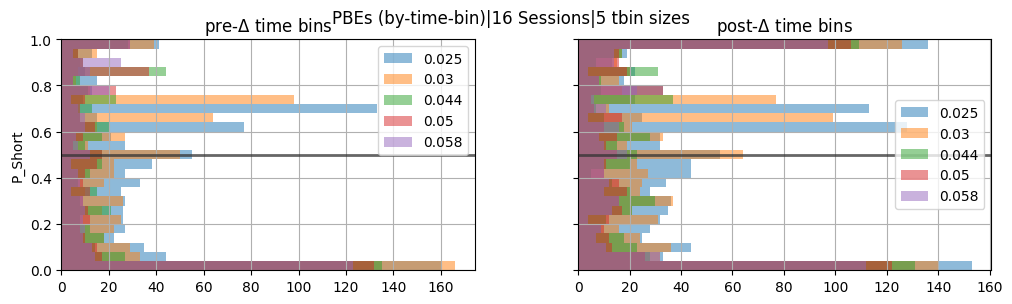

In [ ]:
matplotlib.use('Qt5Agg')
# grainularity_desc: str = 'by-time-bin'
# laps_df: pd.DataFrame = all_sessions_laps_time_bin_df
# ripple_df: pd.DataFrame = all_sessions_ripple_time_bin_df
_out_figs_dict = {}
_laps_histogram_out, _ripple_histogram_out = _perform_dual_hist_plot(grainularity_desc='by-time-bin', laps_df=all_sessions_laps_time_bin_df, ripple_df=all_sessions_ripple_time_bin_df,
                                                                    #   legend_groups_to_solo=[0.025, 0.058], legend_groups_to_hide=None,
                                                                    #   legend_groups_to_solo=None, legend_groups_to_hide=[0.03, 0.0444, 0.05],
                                                                      )

_out_figs_dict[_laps_histogram_out.context.descriptor_str] = _laps_histogram_out.figures[0]
_out_figs_dict[_ripple_histogram_out.context.descriptor_str] = _ripple_histogram_out.figures[0]

# grainularity_desc: str = 'by-epoch'
# laps_df: pd.DataFrame = all_sessions_laps_df
# ripple_df: pd.DataFrame = all_sessions_ripple_df
_laps_histogram_out, _ripple_histogram_out = _perform_dual_hist_plot(grainularity_desc='by-epoch', laps_df=all_sessions_laps_df, ripple_df=all_sessions_ripple_df)
_out_figs_dict[_laps_histogram_out.context.descriptor_str] = _laps_histogram_out.figures[0]
_out_figs_dict[_ripple_histogram_out.context.descriptor_str] = _ripple_histogram_out.figures[0]
_out_figs_dict

In [ ]:

# display(_laps_histogram_out)
# display(_ripple_histogram_out)
fig_to_clipboard(_laps_histogram_out.figures[0], bbox_inches='tight')


In [ ]:
fig_to_clipboard(_ripple_histogram_out.figures[0], bbox_inches='tight')

In [ ]:

fig_to_clipboard(_laps_histogram_out.figures[0], bbox_inches='tight')

In [ ]:
fig_to_clipboard(_ripple_histogram_out.figures[0], bbox_inches='tight')

In [ ]:
from pyphocorehelpers.plotting.media_output_helpers import figure_to_pil_image, vertical_image_stack, horizontal_image_stack, image_grid

# fig_img = figure_to_pil_image(a_fig=_ripple_histogram_out.figures[0])
# fig_img

all_img_list = []
laps_list = []
PBEs_list = []

for a_key, a_fig in _out_figs_dict.items():
    fig_img = figure_to_pil_image(a_fig=a_fig)

    if 'Laps' in a_key:
        laps_list.append(fig_img)
        
    if 'PBEs' in a_key:
        PBEs_list.append(fig_img)
        
    all_img_list.append(fig_img)
    
# all_img_list

# vertical_image_stack(laps_list)
combined_all_img = vertical_image_stack([
    horizontal_image_stack(laps_list),
    horizontal_image_stack(PBEs_list)
])
combined_all_img

copy_image_to_clipboard(combined_all_img)

# 2024-11-18 - Collecting wcorr results from session_data folders:

In [ ]:
from pyphoplacecellanalysis.General.Batch.runBatch import get_file_path_if_file_exists
# from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import copy_session_folder_files_to_target_dir
from pyphocorehelpers.Filesystem.path_helpers import copy_movedict
from neuropy.core.user_annotations import UserAnnotationsManager
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionHelpers

copy_dict, moved_files_dict_files = AcrossSessionHelpers._copy_exported_files_from_session_folder_to_collected_outputs(BATCH_DATE_TO_USE='2024-11-19', cuttoff_date=datetime(2024, 11, 16), target_dir=collected_outputs_directory, is_dry_run=True)
# copy_dict, moved_files_dict_files = AcrossSessionHelpers._copy_exported_files_from_session_folder_to_collected_outputs(BATCH_DATE_TO_USE='2024-11-19', cuttoff_date=datetime(2024, 11, 16), target_dir=collected_outputs_directory, is_dry_run=False)
copy_dict
    

In [ ]:
len(all_found_parsed_csv_files_df_dict[a_session_basedir])
all_found_parsed_csv_files_df_dict[a_session_basedir]['_comparable_custom_replay_name'].unique()
all_found_parsed_csv_files_df_dict[a_session_basedir]['custom_replay_name'].unique()
len(all_found_parsed_csv_files_df_dict[a_session_basedir]['_comparable_custom_replay_name'].unique()), len(all_found_parsed_csv_files_df_dict[a_session_basedir]['custom_replay_name'].unique())
all_found_parsed_csv_files_df_dict[a_session_basedir]['path'].unique()

8, (7, 7) # compare_custom_replay_name_col_name: str = '_comparable_custom_replay_name' ## fewer total entries
9, (7, 8) # compare_custom_replay_name_col_name: str = 'custom_replay_name'

# "2024-11-18_1210PM-kdiba_gor01_one_2006-6-09_1-22-43__withNormalComputedReplays-qclu_[1, 2, 4, 6, 7, 9]-frateThresh_1.0-(ripple_WCorrShuffle_df)_tbin-0.025.csv" # "-" separator
# "2024-11-18_1210PM-kdiba_gor01_one_2006-6-09_1-22-43__withNormalComputedReplays_qclu_[1, 2, 4, 6, 7, 9]_frateThresh_1.0-(ripple_WCorrShuffle_df)_tbin-0.025.csv" # "_" separator

test_path: Path = Path('W:/Data/KDIBA/gor01/one/2006-6-09_1-22-43/output/2024-11-18_1020PM-kdiba_gor01_one_2006-6-09_1-22-43__withNormalComputedReplays_qclu_[1, 2, 4, 6, 7, 9]_frateThresh_1.0-(ripple_WCorrShuffle_df)_tbin-0.025.csv').resolve()
test_path

collected_outputs_directory.joinpath(test_path.name)